The goal of the home price regression competition is to predict the sale price of the home based on information about the home. The competition is described at https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques

The data is described in data_predictions.txt.

Import the necessary packages

In [145]:
# Core
import numpy as np
import pandas as pd
import os
import random
import warnings

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.model_selection import KFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import mutual_info_regression
from sklearn.impute import SimpleImputer
from sklearn.ensemble import IsolationForest

# Tree-based model
import xgboost as xgb
import optuna

Set the random seed to 42 to ensure repeatability.

In [146]:
RANDOM_STATE = 42
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
seed_everything(seed=RANDOM_STATE)

Set the location of the data files based on running on local machine or kaggle website.

In [147]:
KAGGLE = False
warnings.filterwarnings("ignore")

In [148]:
if KAGGLE:
    train_csv = '/kaggle/input/house-prices-advanced-regression-techniques/train.csv'
    test_csv = '/kaggle/input/house-prices-advanced-regression-techniques/test.csv'
else:
    train_csv = '/Users/roberthennessy/Documents/machine learning/house price/data/train.csv'
    test_csv = '/Users/roberthennessy/Documents/machine learning/house price/data/test.csv'
    

train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)

In [149]:
print(train_df.shape)
print(test_df.shape)

(1460, 81)
(1459, 80)


Separate the data into X and y.

Create list of columns that are numeric or categorical.

In [150]:
cat_cols = train_df.drop(columns=['SalePrice', 'Id']).select_dtypes(include=["object"]).columns.tolist()
num_cols = train_df.drop(columns=['SalePrice', 'Id']).select_dtypes(exclude=["object"]).columns.tolist()

len(cat_cols), len(num_cols)

(43, 36)

MSSubClass is a categorical column which is misidentified as numerical column. Month sold and year sold should also be categoriccal because of seasonality.

In [151]:
num_cols

['MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold']

In [152]:
cat_cols.append('MSSubClass')
num_cols.remove('MSSubClass')

cat_cols.append('MoSold')
num_cols.remove('MoSold')

cat_cols.append('YrSold')
num_cols.remove('YrSold')

Remove the Id column

In [153]:
train_df.drop(columns=['Id'], inplace=True)

Check for duplicated rows in the train and test dataset.

In [154]:
print("Duplicated Rows in Train:",train_df.duplicated().sum())
print("Duplicated Rows in Test:",test_df.duplicated().sum())

Duplicated Rows in Train: 0
Duplicated Rows in Test: 0


There are no duplicated rows in the train and test set.

Check for missing values in the data.

In [155]:
def missing_data_table(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = total / len(df)
    missing_data = pd.concat([total, percent], axis=1, keys=["Total", "Percent"])
    # Filter columns that actually have missing values.
    return missing_data[missing_data["Total"] > 0]

print("Missing data in train_df:")
print(missing_data_table(train_df))
print("Missing data in test_df:")
print(missing_data_table(test_df))

Missing data in train_df:
              Total   Percent
PoolQC         1453  0.995205
MiscFeature    1406  0.963014
Alley          1369  0.937671
Fence          1179  0.807534
MasVnrType      872  0.597260
FireplaceQu     690  0.472603
LotFrontage     259  0.177397
GarageYrBlt      81  0.055479
GarageCond       81  0.055479
GarageType       81  0.055479
GarageFinish     81  0.055479
GarageQual       81  0.055479
BsmtExposure     38  0.026027
BsmtFinType2     38  0.026027
BsmtCond         37  0.025342
BsmtQual         37  0.025342
BsmtFinType1     37  0.025342
MasVnrArea        8  0.005479
Electrical        1  0.000685
Missing data in test_df:
              Total   Percent
PoolQC         1456  0.997944
MiscFeature    1408  0.965045
Alley          1352  0.926662
Fence          1169  0.801234
MasVnrType      894  0.612748
FireplaceQu     730  0.500343
LotFrontage     227  0.155586
GarageYrBlt      78  0.053461
GarageQual       78  0.053461
GarageFinish     78  0.053461
GarageCond       78

There are some columns that have a lot of NaNs. However, for some columns, NaNs are expected. For example, pool quality is Na if no pool exists. For those rows, Nas should not be imputed.

In [156]:
print(train_df.dtypes)
discrete_features = [pd.api.types.is_integer_dtype(t) for t in train_df.dtypes]
print(train_df.columns[discrete_features].tolist())

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 80, dtype: object
['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']


In [157]:
rows_na_expected = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']

In [158]:
def find_outliers_iqr(df, column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[column_name] < lower_bound) | (df[column_name] > upper_bound)]
    return outliers

In [159]:
def describe_col(col):
    train_describe = train_df[col].describe()
    train_describe['per missing'] = train_df[col].isnull().sum()/len(train_df)
    train_describe['numb outliers'] = find_outliers_iqr(train_df, col).shape[0]
    train_describe.name = 'train_df'
    test_describe = test_df[col].describe()
    test_describe['per missing'] = test_df[col].isnull().sum()/len(test_df)
    test_describe['numb outliers'] = find_outliers_iqr(test_df, col).shape[0]
    test_describe.name = 'test_df'
    return pd.concat([train_describe, test_describe], axis=1)
print(num_cols[0])
print(describe_col(num_cols[0]))

LotFrontage
                  train_df      test_df
count          1201.000000  1232.000000
mean             70.049958    68.580357
std              24.284752    22.376841
min              21.000000    21.000000
25%              59.000000    58.000000
50%              69.000000    67.000000
75%              80.000000    80.000000
max             313.000000   200.000000
per missing       0.177397     0.155586
numb outliers    88.000000   100.000000


In [160]:
def plot_overlaid_histograms(df1, df2, col, df1_label, df2_label, bins):
    # Plot overlaid histograms
    plt.hist(df1[col], bins=bins, alpha=0.7, label=df1_label, color='blue')
    plt.hist(df2[col], bins=bins, alpha=0.7, label=df2_label, color='orange')

    plt.title('Overlaid Histograms')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

def plot_multi_hist(df1, df2, col, df1_label, df2_label, bins):
    fig, axs = plt.subplots(1, 2, figsize=(15,6)) # 1 row, 2 columns
    axs[0].hist(df1[col], bins=bins, color='blue')
    axs[0].set_title(df1_label)
    axs[1].hist(df2[col], bins=bins, label=df2_label, color='orange')
    axs[1].set_title(df2_label)
    plt.show()

def plot_multi_hist2(df1, df2, col, df1_label, df2_label, bins):
    fig, axs = plt.subplots(1, 2, figsize=(15,6)) # 1 row, 2 columns
    df1[col].value_counts().sort_index(ascending=False).plot.hist(bins=bins, color='blue', ax=axs[0], title=df1_label)
    df2[col].value_counts().sort_index(ascending=False).plot.hist(bins=bins, color='orange', ax=axs[1], title=df2_label)
    plt.show()

def plot_multi_bar(df1, df2, col, df1_label, df2_label):
    fig, axs = plt.subplots(1, 2, figsize=(15,6)) # 1 row, 2 columns
    df1[col].value_counts().plot.bar(color='blue', ax=axs[0], title=df1_label)
    df2[col].value_counts().plot.bar(color='orange', ax=axs[1], title=df2_label)
    plt.show()

LotFrontage
                  train_df      test_df
count          1201.000000  1232.000000
mean             70.049958    68.580357
std              24.284752    22.376841
min              21.000000    21.000000
25%              59.000000    58.000000
50%              69.000000    67.000000
75%              80.000000    80.000000
max             313.000000   200.000000
per missing       0.177397     0.155586
numb outliers    88.000000   100.000000


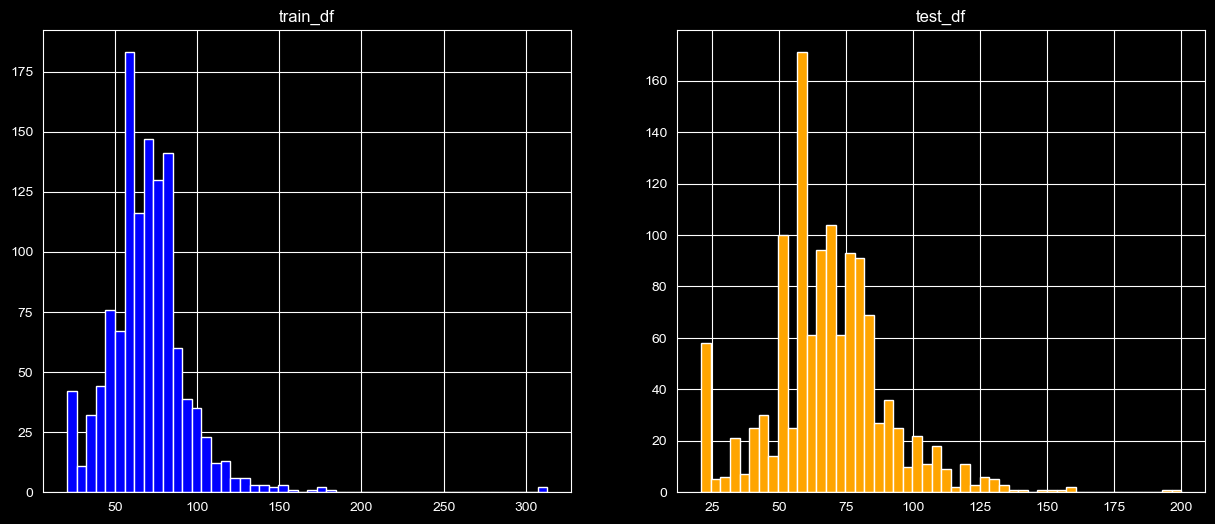

LotArea
                    train_df       test_df
count            1460.000000   1459.000000
mean            10516.828082   9819.161069
std              9981.264932   4955.517327
min              1300.000000   1470.000000
25%              7553.500000   7391.000000
50%              9478.500000   9399.000000
75%             11601.500000  11517.500000
max            215245.000000  56600.000000
per missing         0.000000      0.000000
numb outliers      69.000000     60.000000


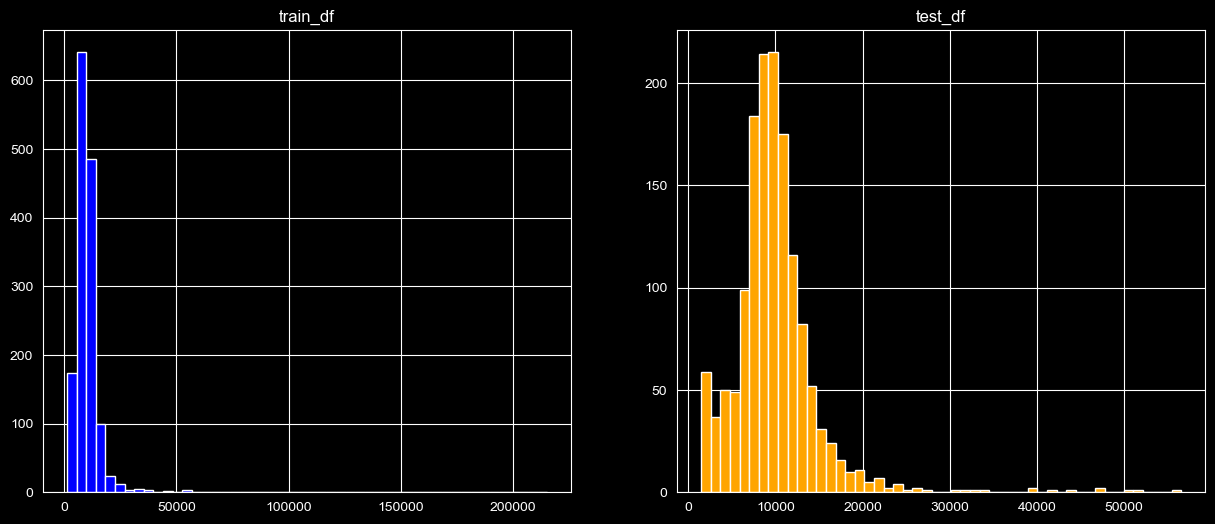

OverallQual
                  train_df      test_df
count          1460.000000  1459.000000
mean              6.099315     6.078821
std               1.382997     1.436812
min               1.000000     1.000000
25%               5.000000     5.000000
50%               6.000000     6.000000
75%               7.000000     7.000000
max              10.000000    10.000000
per missing       0.000000     0.000000
numb outliers     2.000000     2.000000


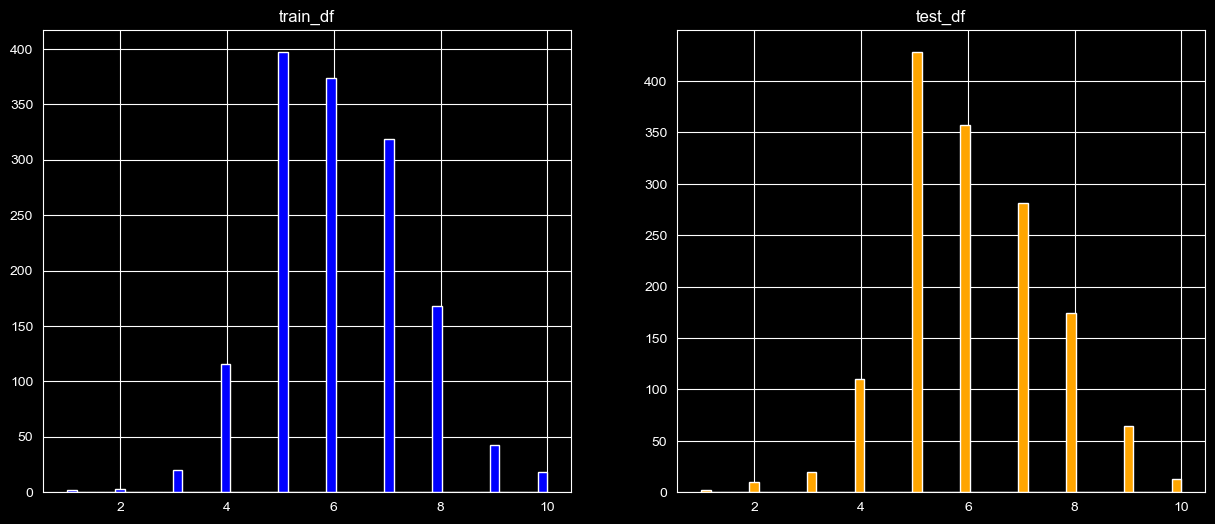

OverallCond
                  train_df      test_df
count          1460.000000  1459.000000
mean              5.575342     5.553804
std               1.112799     1.113740
min               1.000000     1.000000
25%               5.000000     5.000000
50%               5.000000     5.000000
75%               6.000000     6.000000
max               9.000000     9.000000
per missing       0.000000     0.000000
numb outliers   125.000000   127.000000


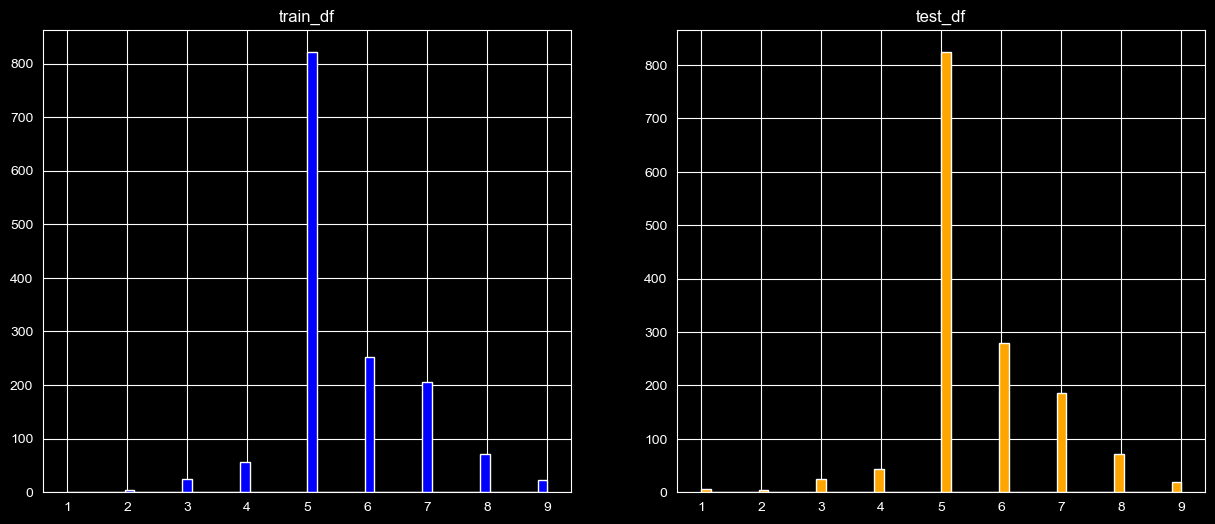

YearBuilt
                  train_df      test_df
count          1460.000000  1459.000000
mean           1971.267808  1971.357779
std              30.202904    30.390071
min            1872.000000  1879.000000
25%            1954.000000  1953.000000
50%            1973.000000  1973.000000
75%            2000.000000  2001.000000
max            2010.000000  2010.000000
per missing       0.000000     0.000000
numb outliers     7.000000     2.000000


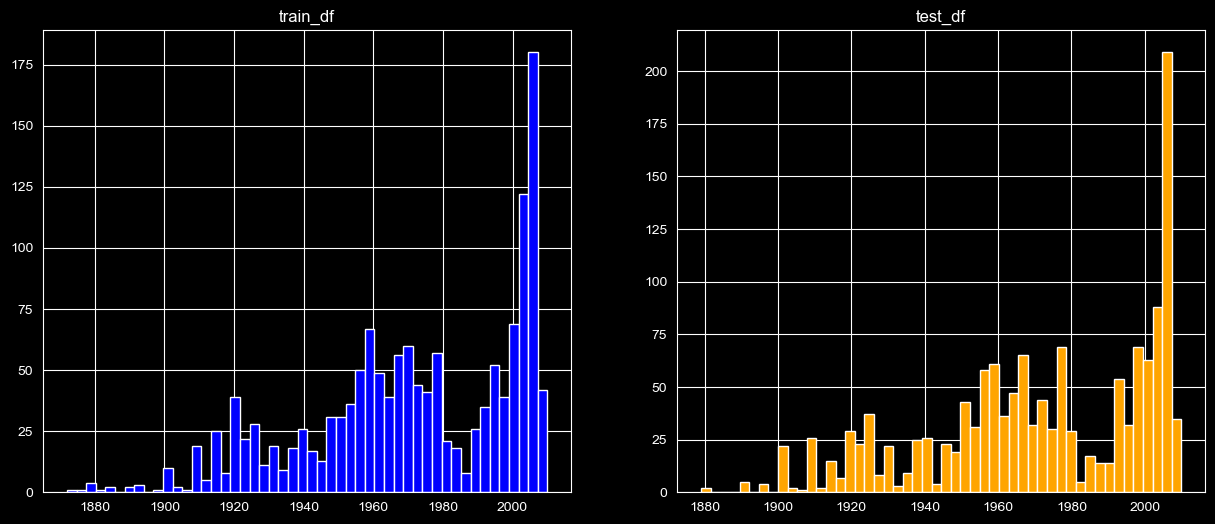

YearRemodAdd
                  train_df      test_df
count          1460.000000  1459.000000
mean           1984.865753  1983.662783
std              20.645407    21.130467
min            1950.000000  1950.000000
25%            1967.000000  1963.000000
50%            1994.000000  1992.000000
75%            2004.000000  2004.000000
max            2010.000000  2010.000000
per missing       0.000000     0.000000
numb outliers     0.000000     0.000000


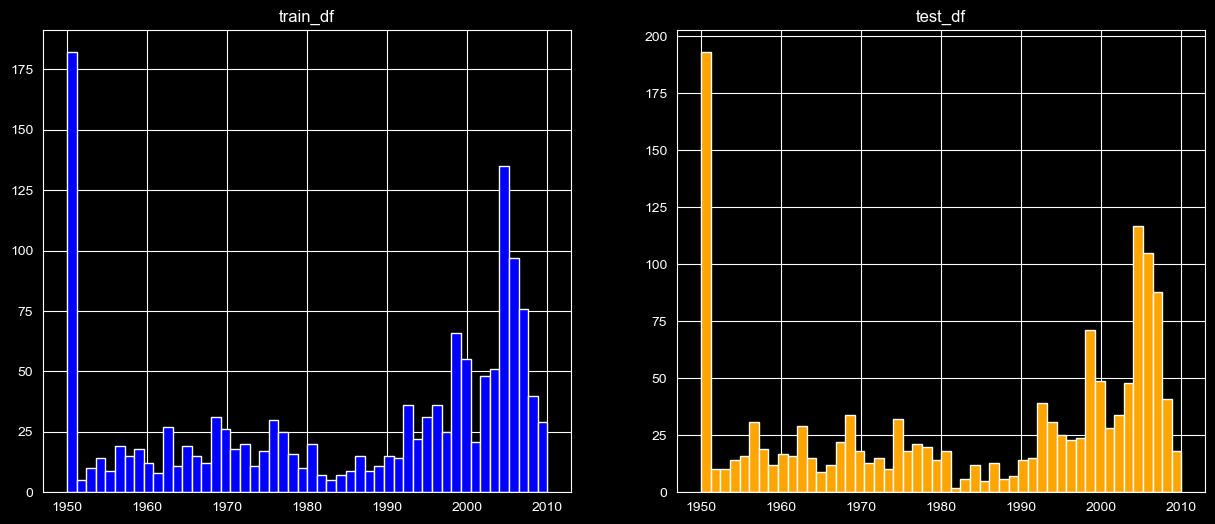

MasVnrArea
                  train_df      test_df
count          1452.000000  1444.000000
mean            103.685262   100.709141
std             181.066207   177.625900
min               0.000000     0.000000
25%               0.000000     0.000000
50%               0.000000     0.000000
75%             166.000000   164.000000
max            1600.000000  1290.000000
per missing       0.005479     0.010281
numb outliers    96.000000   102.000000


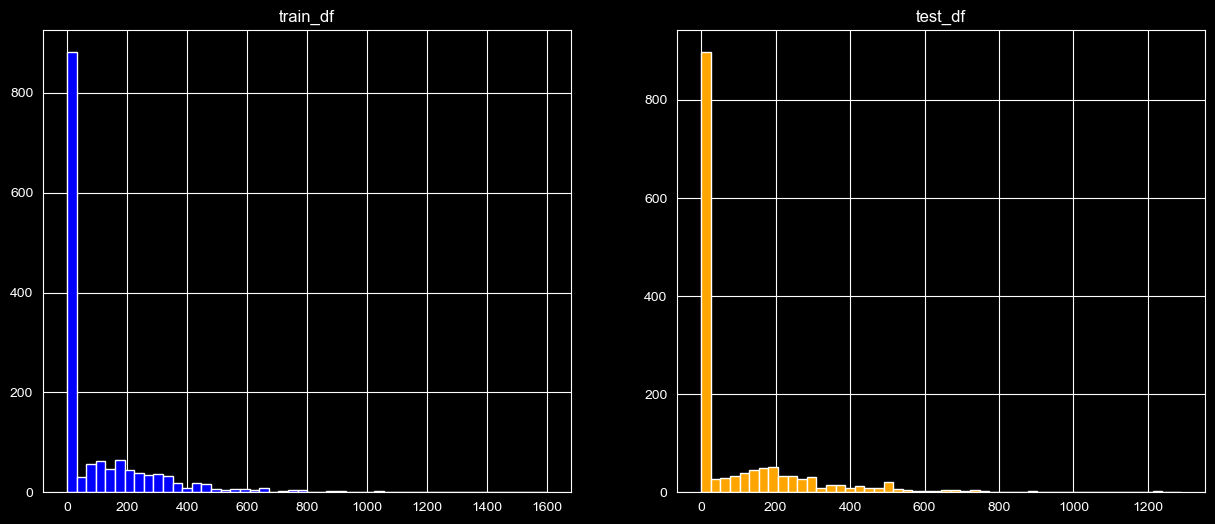

BsmtFinSF1
                  train_df      test_df
count          1460.000000  1458.000000
mean            443.639726   439.203704
std             456.098091   455.268042
min               0.000000     0.000000
25%               0.000000     0.000000
50%             383.500000   350.500000
75%             712.250000   753.500000
max            5644.000000  4010.000000
per missing       0.000000     0.000685
numb outliers     7.000000     8.000000


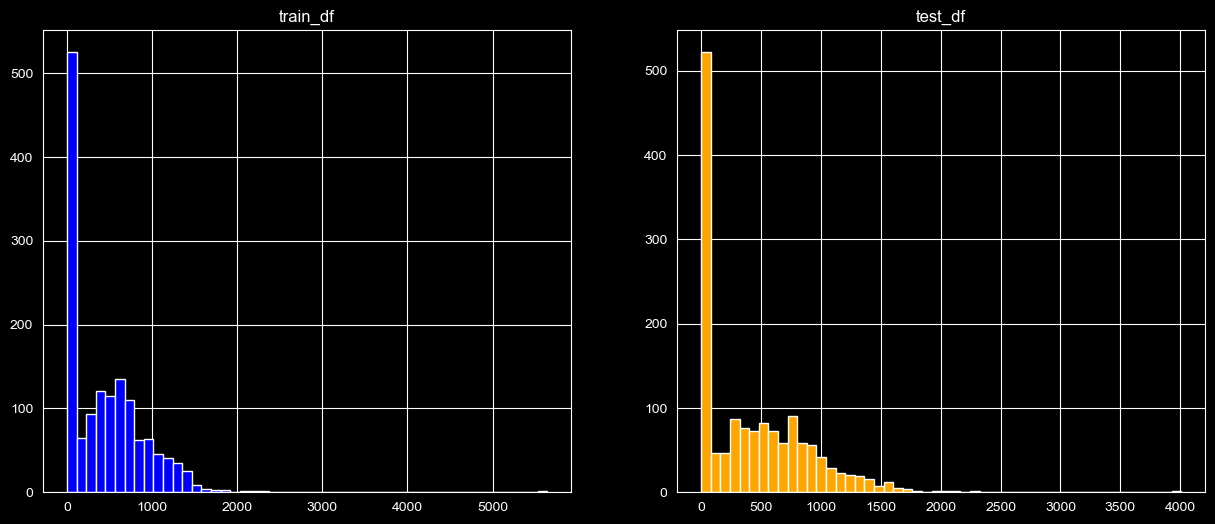

BsmtFinSF2
                  train_df      test_df
count          1460.000000  1458.000000
mean             46.549315    52.619342
std             161.319273   176.753926
min               0.000000     0.000000
25%               0.000000     0.000000
50%               0.000000     0.000000
75%               0.000000     0.000000
max            1474.000000  1526.000000
per missing       0.000000     0.000685
numb outliers   167.000000   180.000000


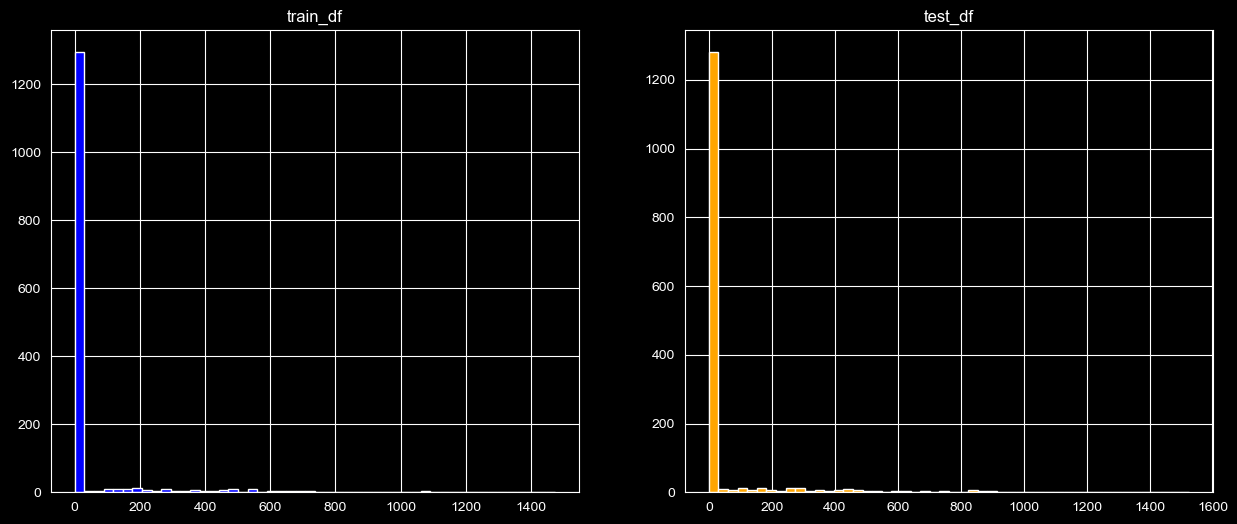

BsmtUnfSF
                  train_df      test_df
count          1460.000000  1458.000000
mean            567.240411   554.294925
std             441.866955   437.260486
min               0.000000     0.000000
25%             223.000000   219.250000
50%             477.500000   460.000000
75%             808.000000   797.750000
max            2336.000000  2140.000000
per missing       0.000000     0.000685
numb outliers    29.000000    26.000000


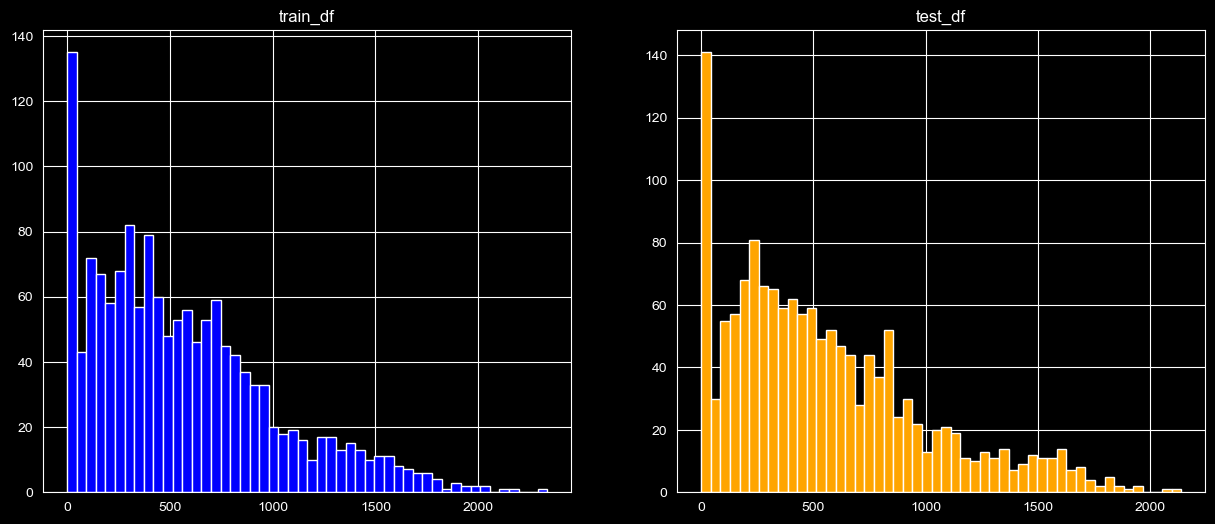

TotalBsmtSF
                  train_df      test_df
count          1460.000000  1458.000000
mean           1057.429452  1046.117970
std             438.705324   442.898624
min               0.000000     0.000000
25%             795.750000   784.000000
50%             991.500000   988.000000
75%            1298.250000  1305.000000
max            6110.000000  5095.000000
per missing       0.000000     0.000685
numb outliers    61.000000    61.000000


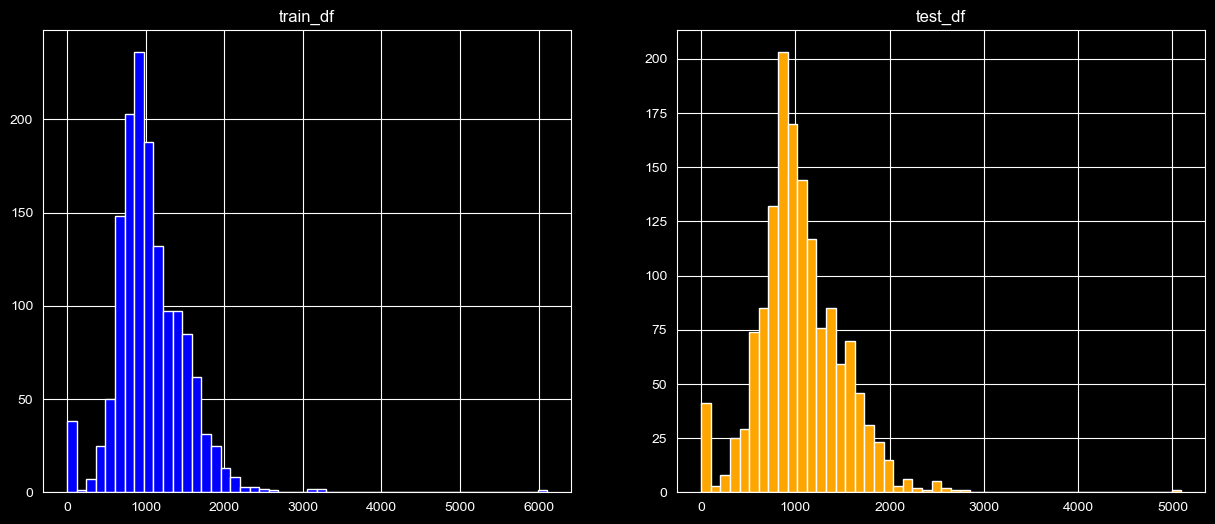

1stFlrSF
                  train_df      test_df
count          1460.000000  1459.000000
mean           1162.626712  1156.534613
std             386.587738   398.165820
min             334.000000   407.000000
25%             882.000000   873.500000
50%            1087.000000  1079.000000
75%            1391.250000  1382.500000
max            4692.000000  5095.000000
per missing       0.000000     0.000000
numb outliers    20.000000    23.000000


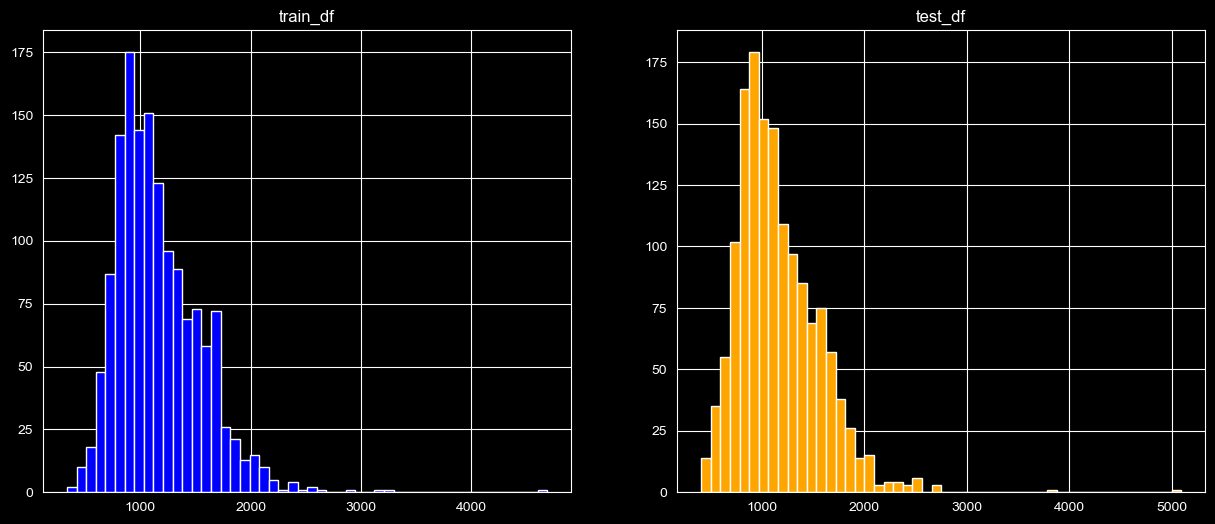

2ndFlrSF
                  train_df      test_df
count          1460.000000  1459.000000
mean            346.992466   325.967786
std             436.528436   420.610226
min               0.000000     0.000000
25%               0.000000     0.000000
50%               0.000000     0.000000
75%             728.000000   676.000000
max            2065.000000  1862.000000
per missing       0.000000     0.000000
numb outliers     2.000000     5.000000


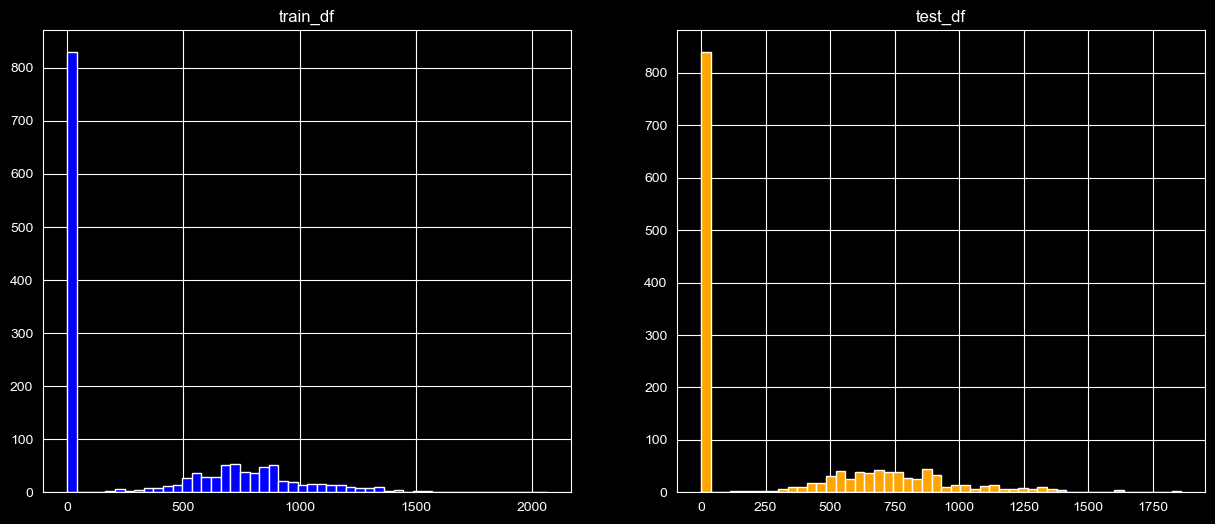

LowQualFinSF
                  train_df      test_df
count          1460.000000  1459.000000
mean              5.844521     3.543523
std              48.623081    44.043251
min               0.000000     0.000000
25%               0.000000     0.000000
50%               0.000000     0.000000
75%               0.000000     0.000000
max             572.000000  1064.000000
per missing       0.000000     0.000000
numb outliers    26.000000    14.000000


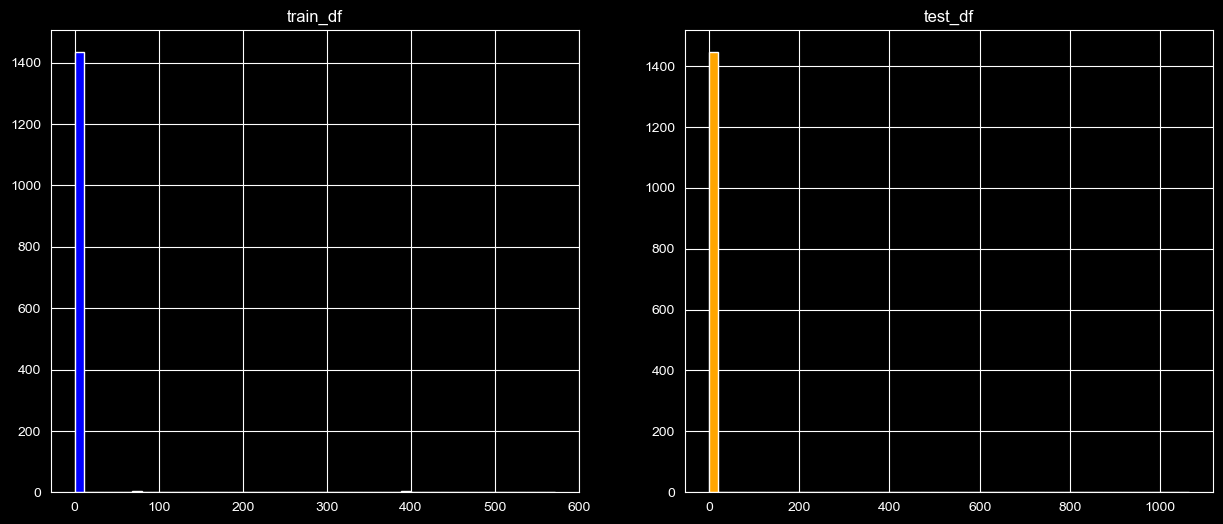

GrLivArea
                  train_df      test_df
count          1460.000000  1459.000000
mean           1515.463699  1486.045922
std             525.480383   485.566099
min             334.000000   407.000000
25%            1129.500000  1117.500000
50%            1464.000000  1432.000000
75%            1776.750000  1721.000000
max            5642.000000  5095.000000
per missing       0.000000     0.000000
numb outliers    31.000000    44.000000


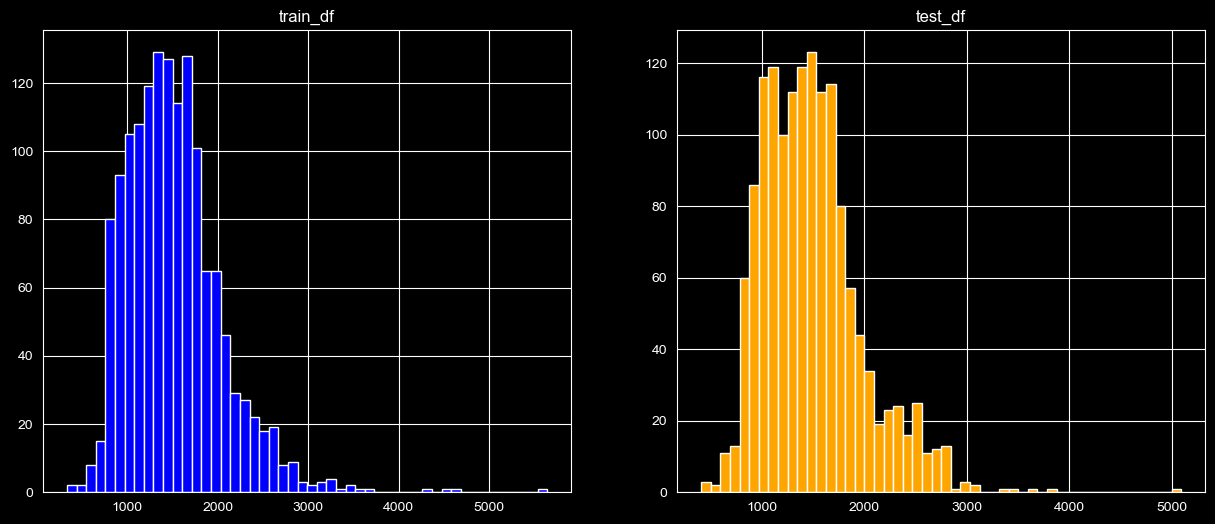

BsmtFullBath
                  train_df      test_df
count          1460.000000  1457.000000
mean              0.425342     0.434454
std               0.518911     0.530648
min               0.000000     0.000000
25%               0.000000     0.000000
50%               0.000000     0.000000
75%               1.000000     1.000000
max               3.000000     3.000000
per missing       0.000000     0.001371
numb outliers     1.000000     1.000000


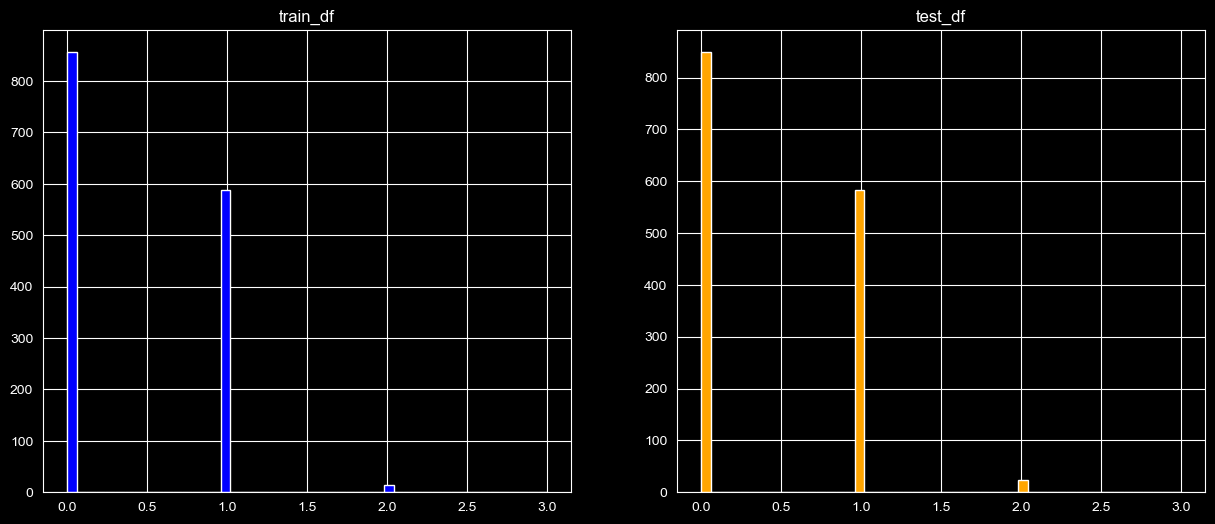

BsmtHalfBath
                  train_df      test_df
count          1460.000000  1457.000000
mean              0.057534     0.065202
std               0.238753     0.252468
min               0.000000     0.000000
25%               0.000000     0.000000
50%               0.000000     0.000000
75%               0.000000     0.000000
max               2.000000     2.000000
per missing       0.000000     0.001371
numb outliers    82.000000    93.000000


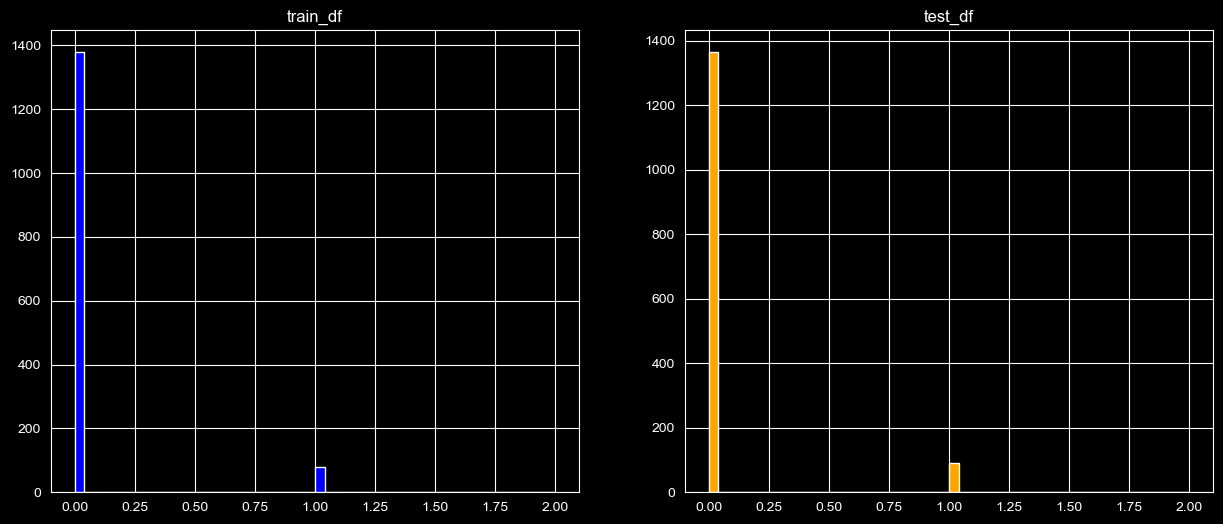

FullBath
                  train_df      test_df
count          1460.000000  1459.000000
mean              1.565068     1.570939
std               0.550916     0.555190
min               0.000000     0.000000
25%               1.000000     1.000000
50%               2.000000     2.000000
75%               2.000000     2.000000
max               3.000000     4.000000
per missing       0.000000     0.000000
numb outliers     0.000000     4.000000


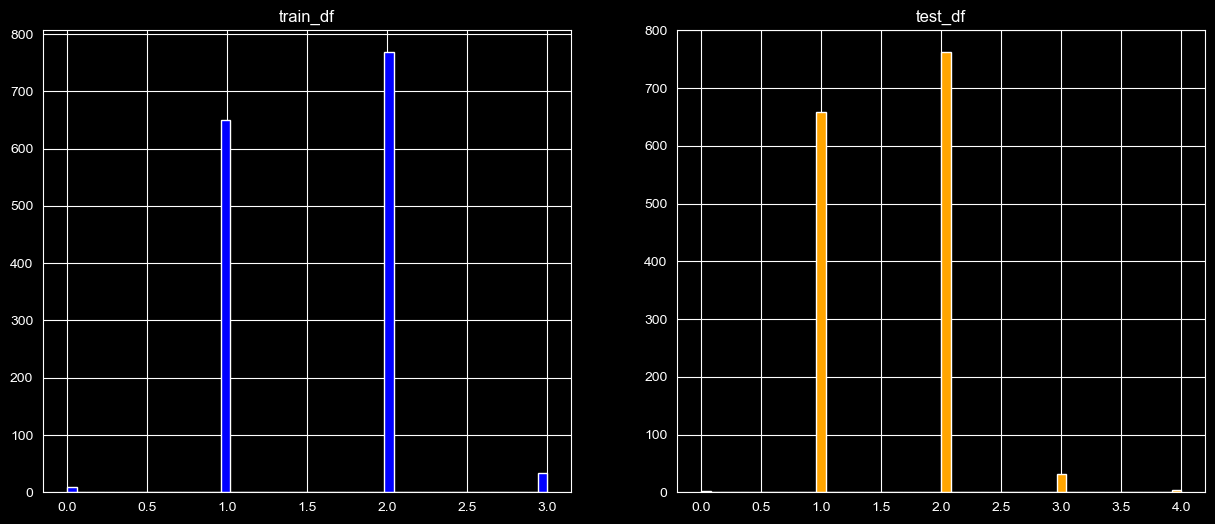

HalfBath
                  train_df      test_df
count          1460.000000  1459.000000
mean              0.382877     0.377656
std               0.502885     0.503017
min               0.000000     0.000000
25%               0.000000     0.000000
50%               0.000000     0.000000
75%               1.000000     1.000000
max               2.000000     2.000000
per missing       0.000000     0.000000
numb outliers     0.000000     0.000000


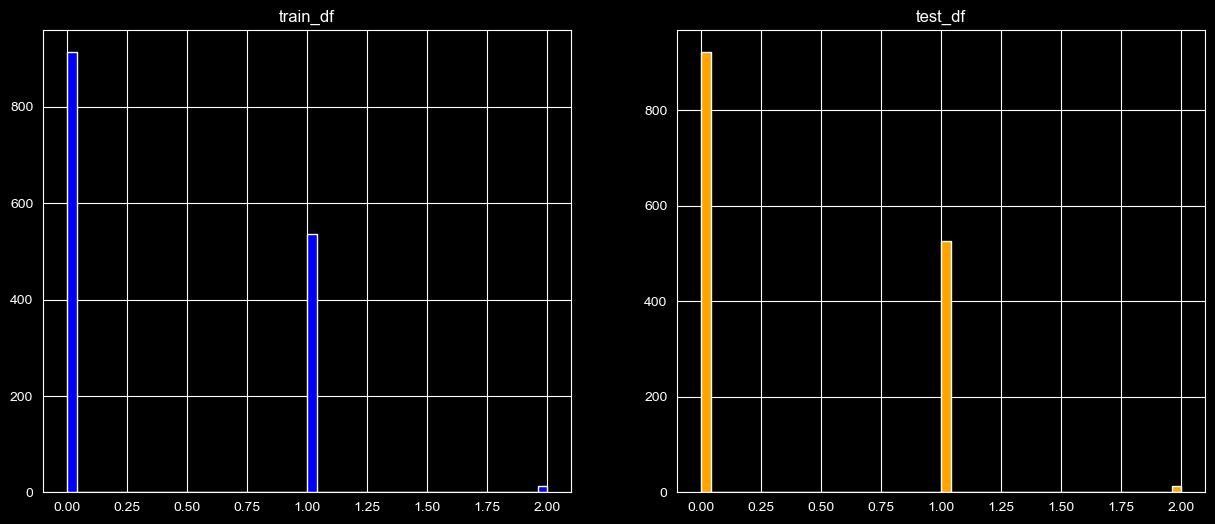

BedroomAbvGr
                  train_df      test_df
count          1460.000000  1459.000000
mean              2.866438     2.854010
std               0.815778     0.829788
min               0.000000     0.000000
25%               2.000000     2.000000
50%               3.000000     3.000000
75%               3.000000     3.000000
max               8.000000     6.000000
per missing       0.000000     0.000000
numb outliers    35.000000    43.000000


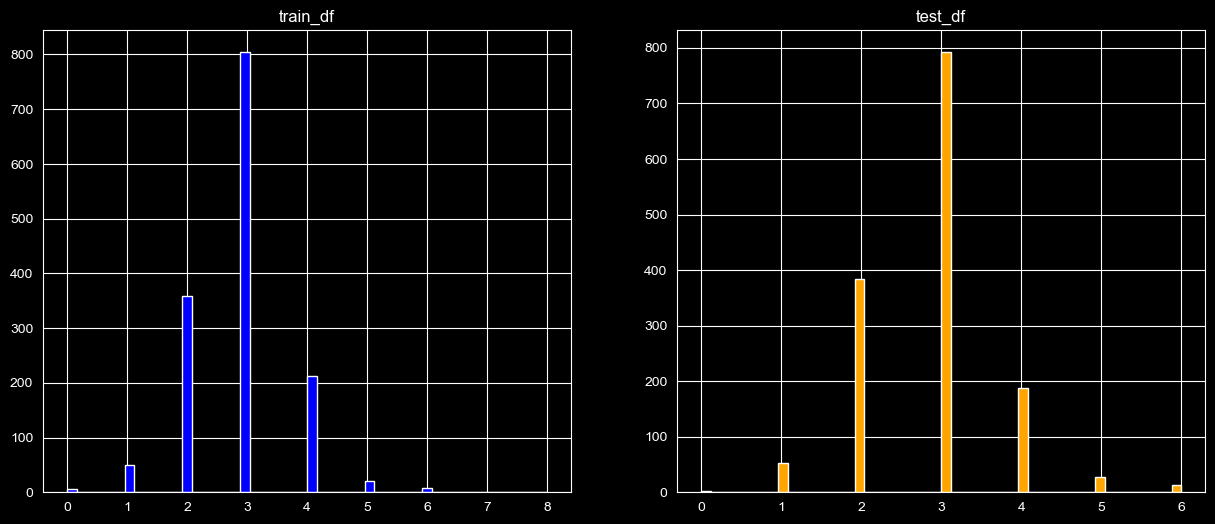

KitchenAbvGr
                  train_df      test_df
count          1460.000000  1459.000000
mean              1.046575     1.042495
std               0.220338     0.208472
min               0.000000     0.000000
25%               1.000000     1.000000
50%               1.000000     1.000000
75%               1.000000     1.000000
max               3.000000     2.000000
per missing       0.000000     0.000000
numb outliers    68.000000    66.000000


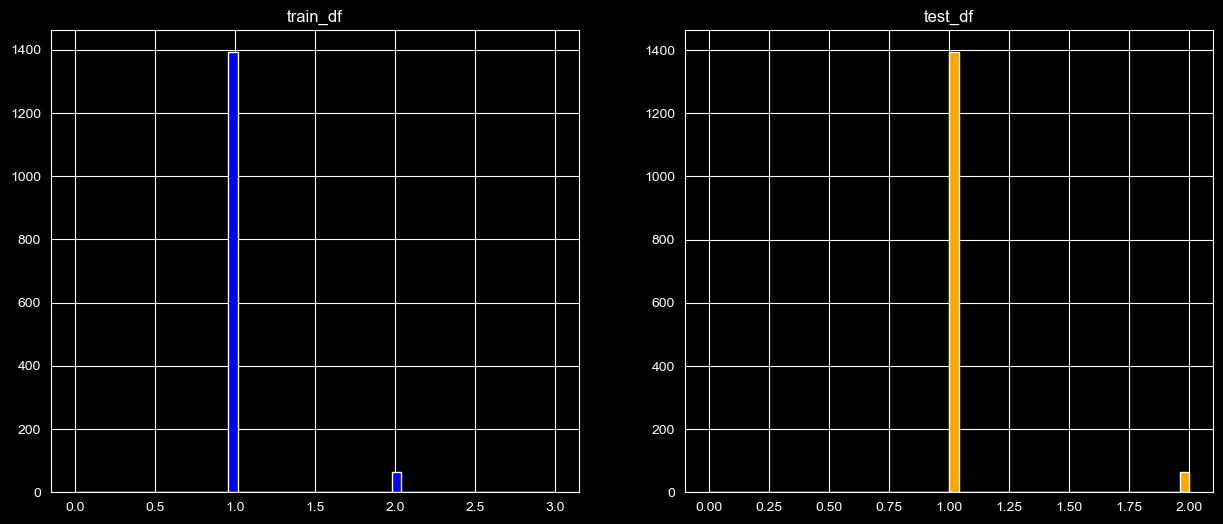

TotRmsAbvGrd
                  train_df      test_df
count          1460.000000  1459.000000
mean              6.517808     6.385195
std               1.625393     1.508895
min               2.000000     3.000000
25%               5.000000     5.000000
50%               6.000000     6.000000
75%               7.000000     7.000000
max              14.000000    15.000000
per missing       0.000000     0.000000
numb outliers    30.000000    21.000000


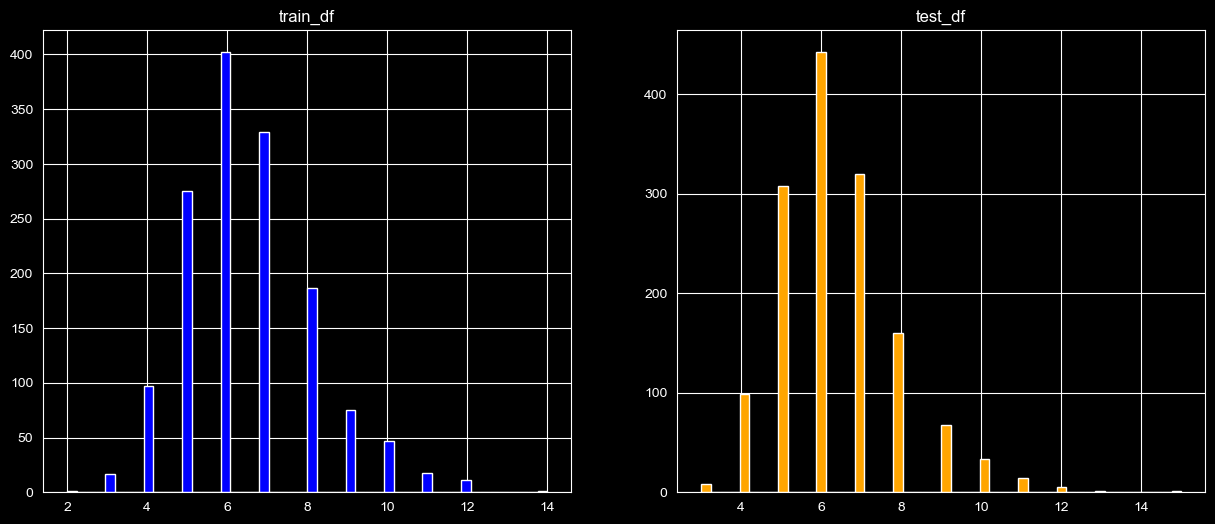

Fireplaces
                  train_df     test_df
count          1460.000000  1459.00000
mean              0.613014     0.58122
std               0.644666     0.64742
min               0.000000     0.00000
25%               0.000000     0.00000
50%               1.000000     0.00000
75%               1.000000     1.00000
max               3.000000     4.00000
per missing       0.000000     0.00000
numb outliers     5.000000     7.00000


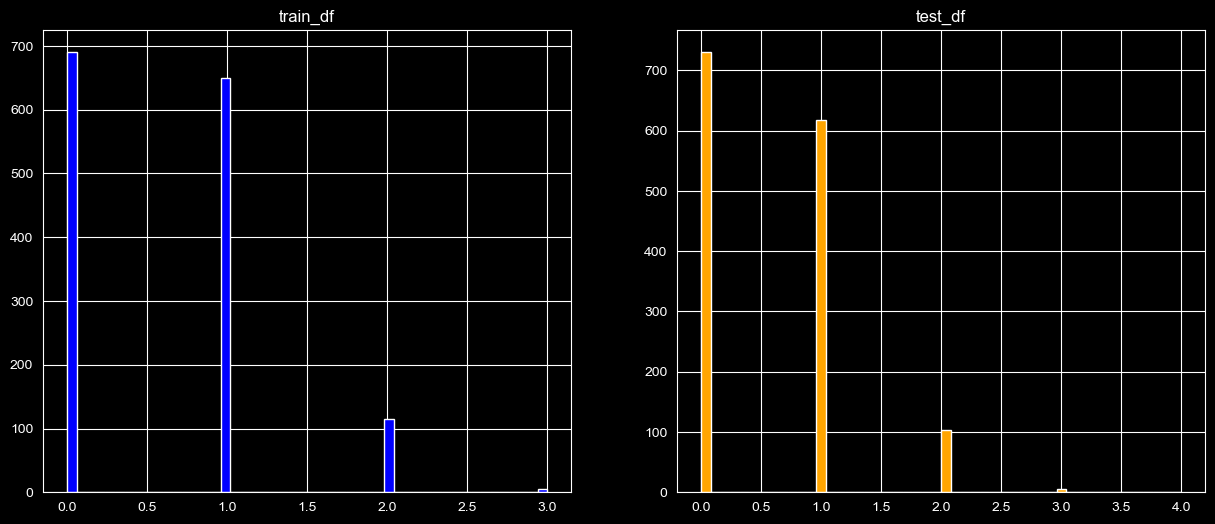

GarageYrBlt
                  train_df      test_df
count          1379.000000  1381.000000
mean           1978.506164  1977.721217
std              24.689725    26.431175
min            1900.000000  1895.000000
25%            1961.000000  1959.000000
50%            1980.000000  1979.000000
75%            2002.000000  2002.000000
max            2010.000000  2207.000000
per missing       0.055479     0.053461
numb outliers     0.000000     1.000000


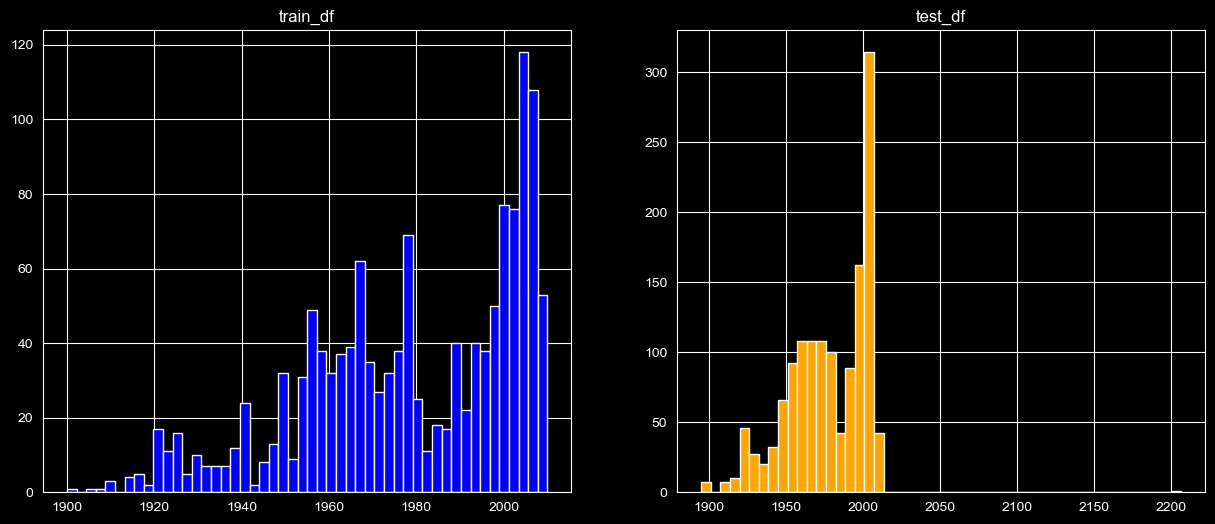

GarageCars
                  train_df      test_df
count          1460.000000  1458.000000
mean              1.767123     1.766118
std               0.747315     0.775945
min               0.000000     0.000000
25%               1.000000     1.000000
50%               2.000000     2.000000
75%               2.000000     2.000000
max               4.000000     5.000000
per missing       0.000000     0.000685
numb outliers     5.000000    12.000000


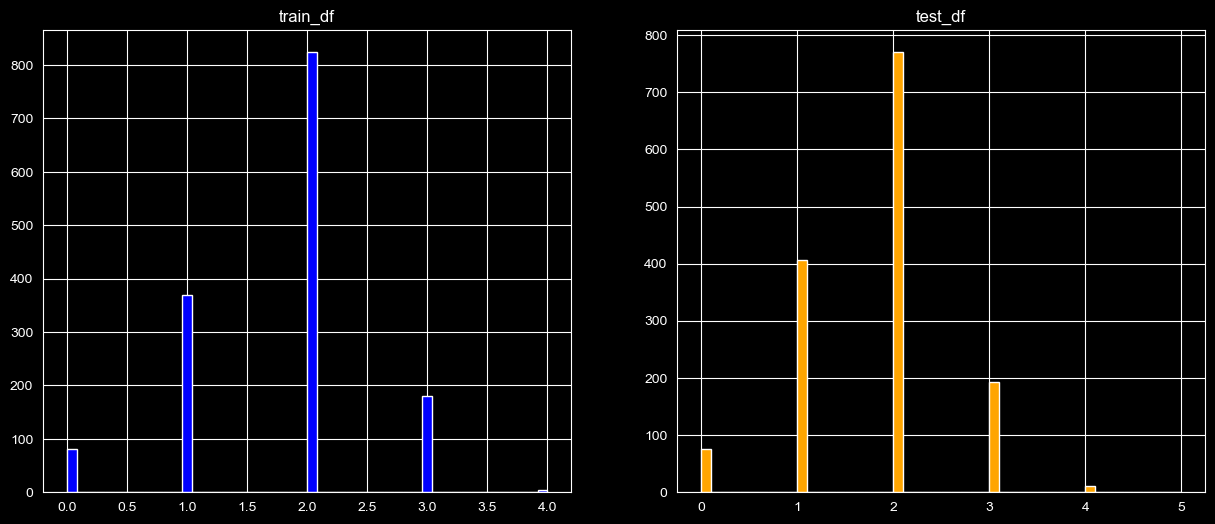

GarageArea
                  train_df      test_df
count          1460.000000  1458.000000
mean            472.980137   472.768861
std             213.804841   217.048611
min               0.000000     0.000000
25%             334.500000   318.000000
50%             480.000000   480.000000
75%             576.000000   576.000000
max            1418.000000  1488.000000
per missing       0.000000     0.000685
numb outliers    21.000000    21.000000


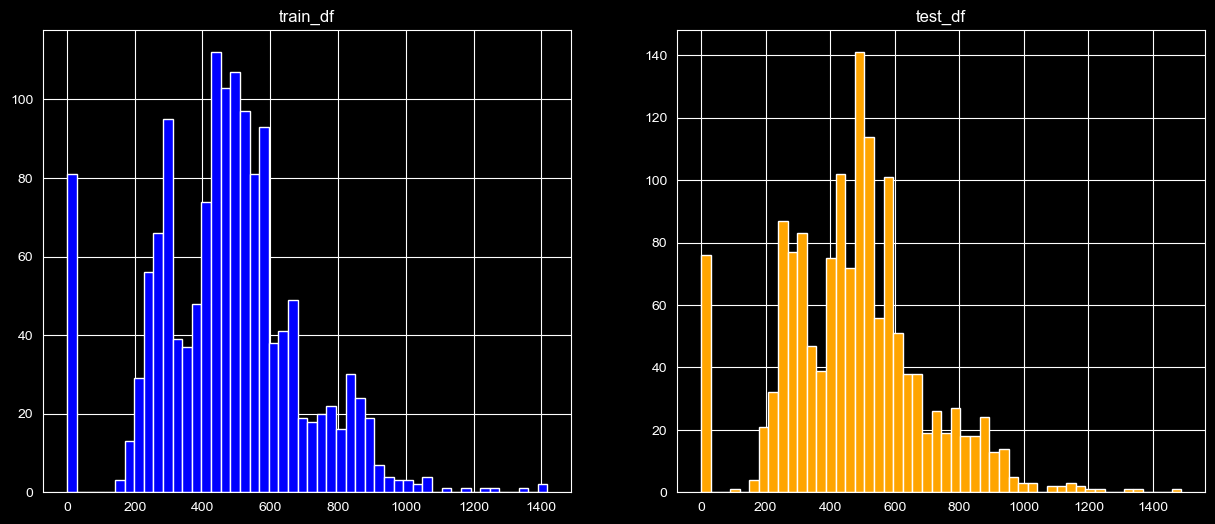

WoodDeckSF
                  train_df      test_df
count          1460.000000  1459.000000
mean             94.244521    93.174777
std             125.338794   127.744882
min               0.000000     0.000000
25%               0.000000     0.000000
50%               0.000000     0.000000
75%             168.000000   168.000000
max             857.000000  1424.000000
per missing       0.000000     0.000000
numb outliers    32.000000    35.000000


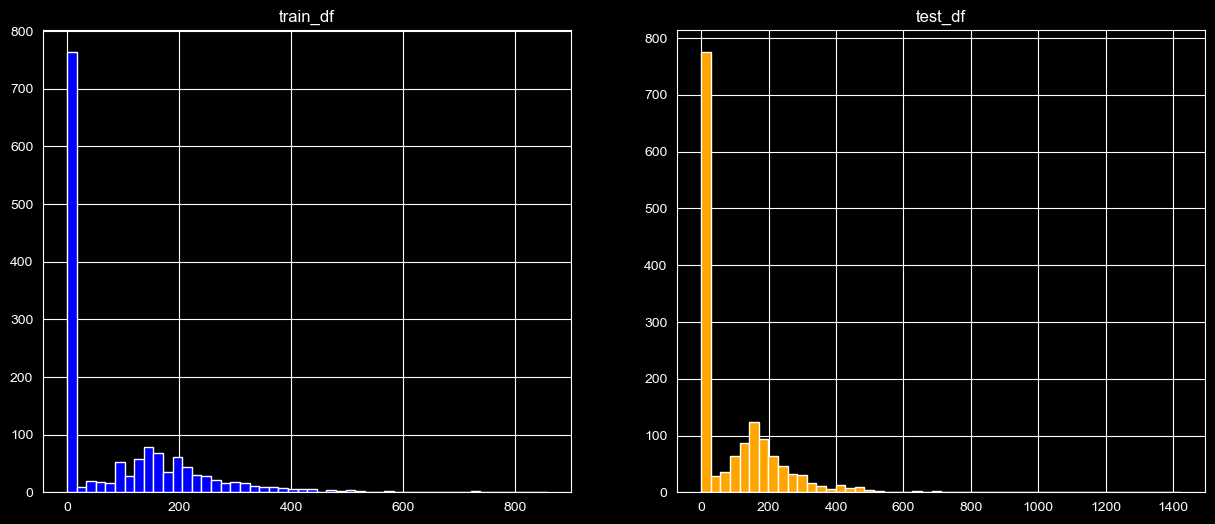

OpenPorchSF
                  train_df      test_df
count          1460.000000  1459.000000
mean             46.660274    48.313914
std              66.256028    68.883364
min               0.000000     0.000000
25%               0.000000     0.000000
50%              25.000000    28.000000
75%              68.000000    72.000000
max             547.000000   742.000000
per missing       0.000000     0.000000
numb outliers    77.000000    79.000000


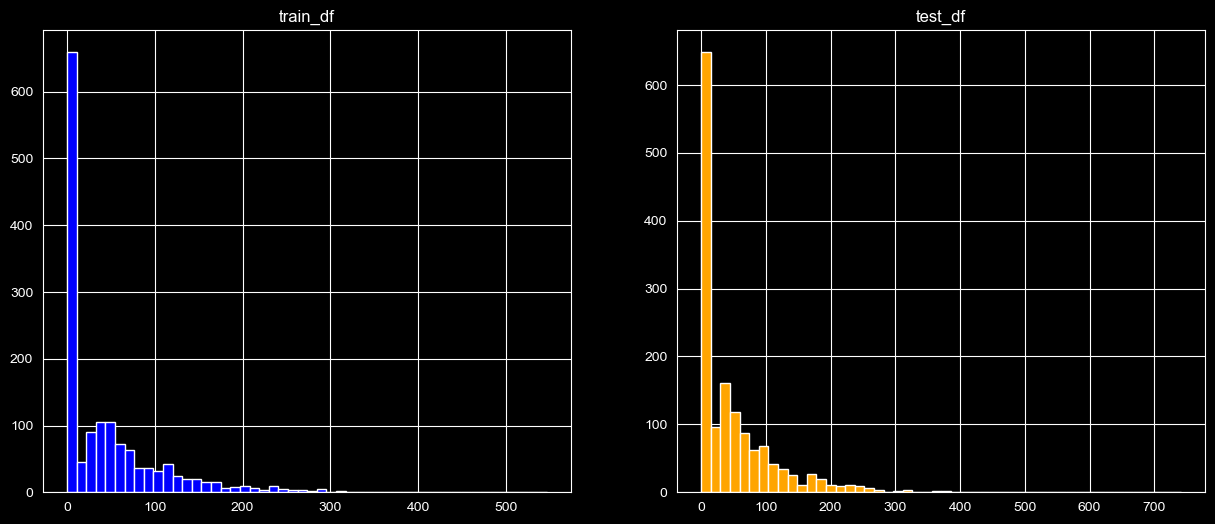

EnclosedPorch
                  train_df      test_df
count          1460.000000  1459.000000
mean             21.954110    24.243317
std              61.119149    67.227765
min               0.000000     0.000000
25%               0.000000     0.000000
50%               0.000000     0.000000
75%               0.000000     0.000000
max             552.000000  1012.000000
per missing       0.000000     0.000000
numb outliers   208.000000   251.000000


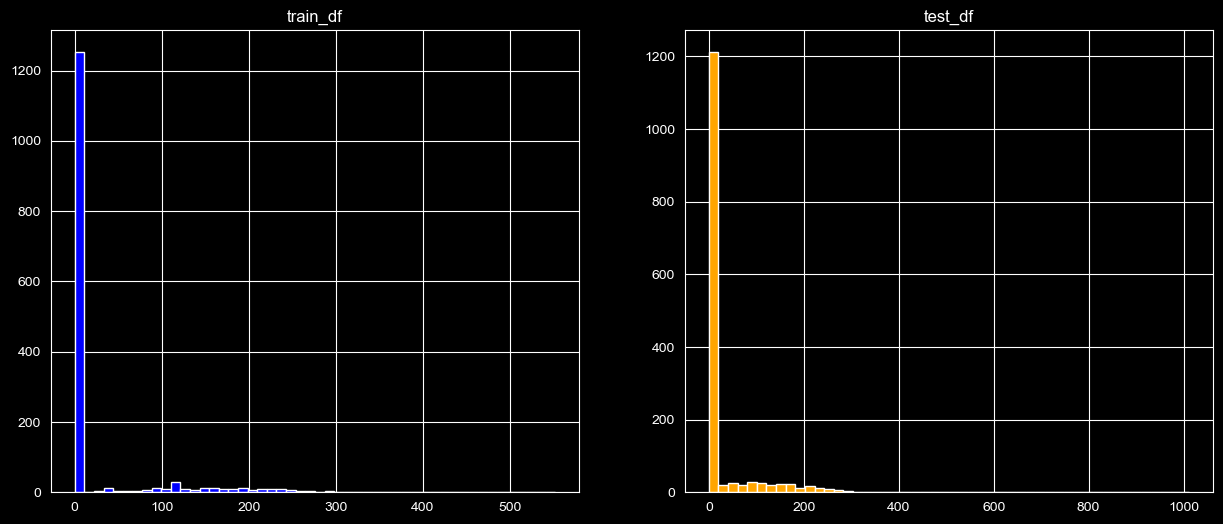

3SsnPorch
                  train_df      test_df
count          1460.000000  1459.000000
mean              3.409589     1.794380
std              29.317331    20.207842
min               0.000000     0.000000
25%               0.000000     0.000000
50%               0.000000     0.000000
75%               0.000000     0.000000
max             508.000000   360.000000
per missing       0.000000     0.000000
numb outliers    24.000000    13.000000


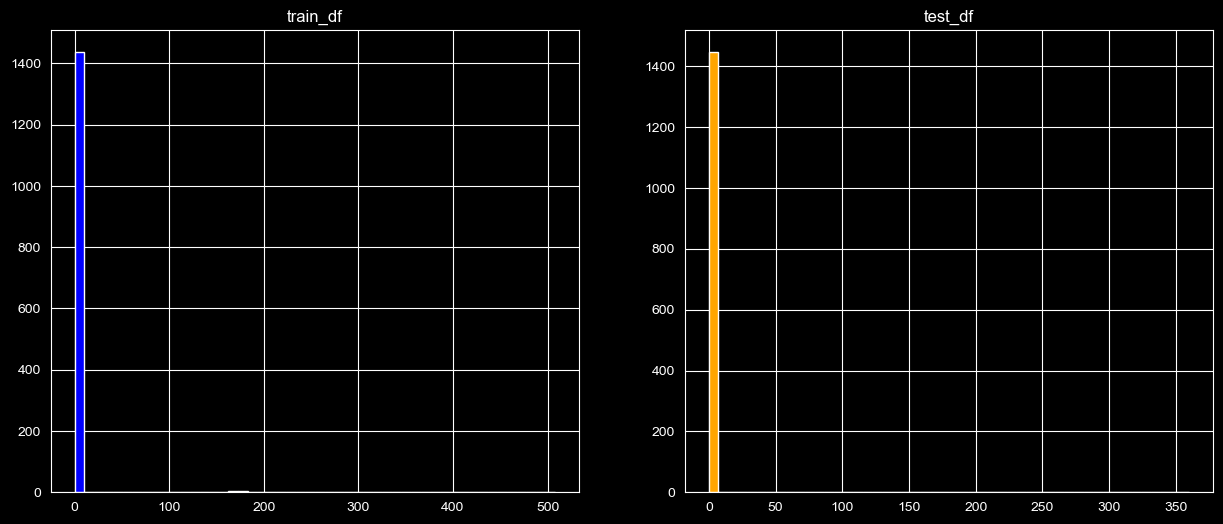

ScreenPorch
                  train_df      test_df
count          1460.000000  1459.000000
mean             15.060959    17.064428
std              55.757415    56.609763
min               0.000000     0.000000
25%               0.000000     0.000000
50%               0.000000     0.000000
75%               0.000000     0.000000
max             480.000000   576.000000
per missing       0.000000     0.000000
numb outliers   116.000000   140.000000


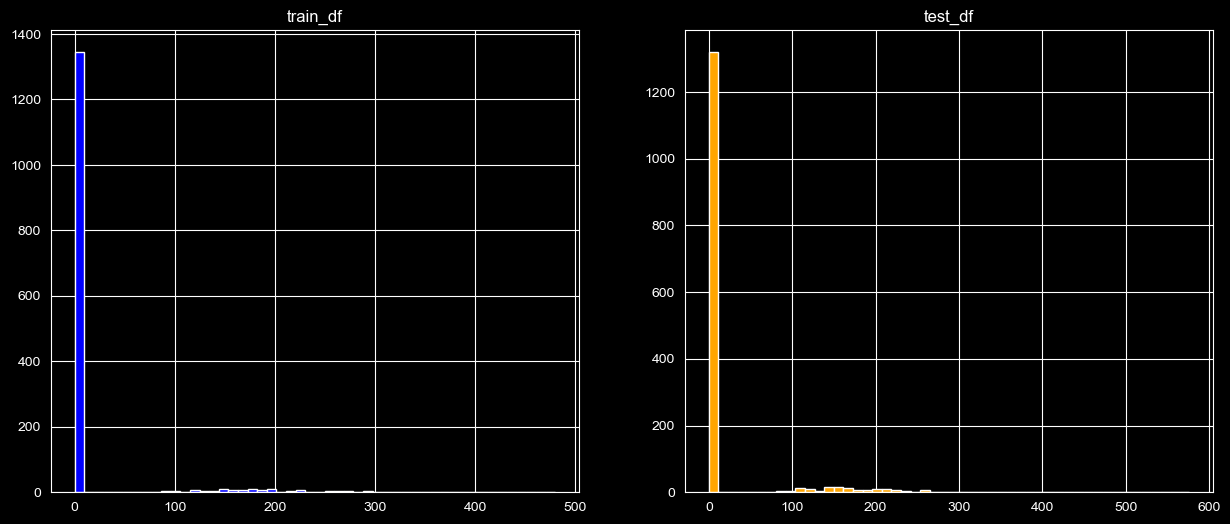

PoolArea
                  train_df      test_df
count          1460.000000  1459.000000
mean              2.758904     1.744345
std              40.177307    30.491646
min               0.000000     0.000000
25%               0.000000     0.000000
50%               0.000000     0.000000
75%               0.000000     0.000000
max             738.000000   800.000000
per missing       0.000000     0.000000
numb outliers     7.000000     6.000000


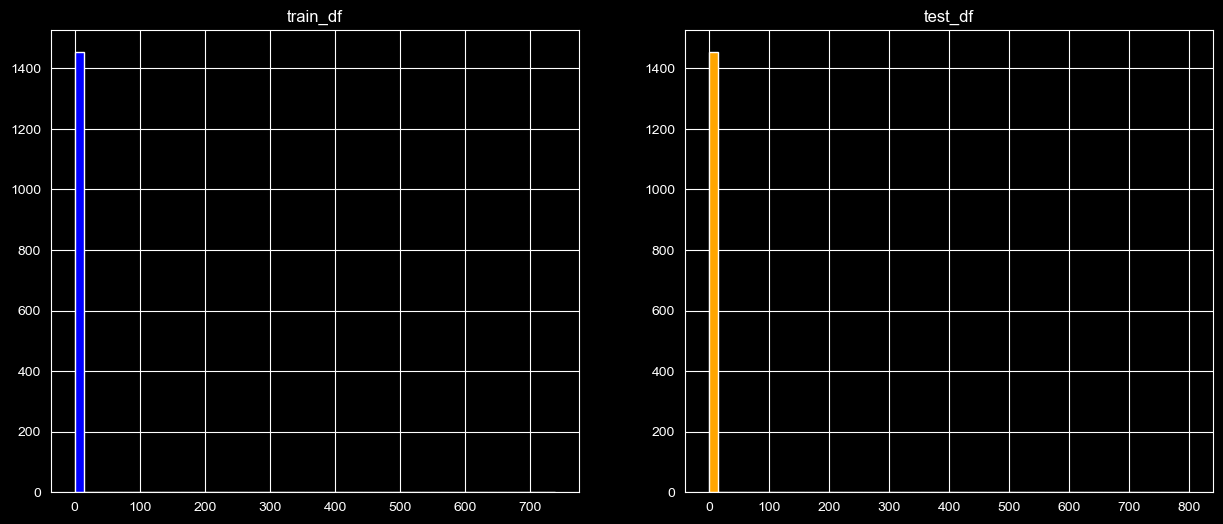

MiscVal
                   train_df       test_df
count           1460.000000   1459.000000
mean              43.489041     58.167923
std              496.123024    630.806978
min                0.000000      0.000000
25%                0.000000      0.000000
50%                0.000000      0.000000
75%                0.000000      0.000000
max            15500.000000  17000.000000
per missing        0.000000      0.000000
numb outliers     52.000000     51.000000


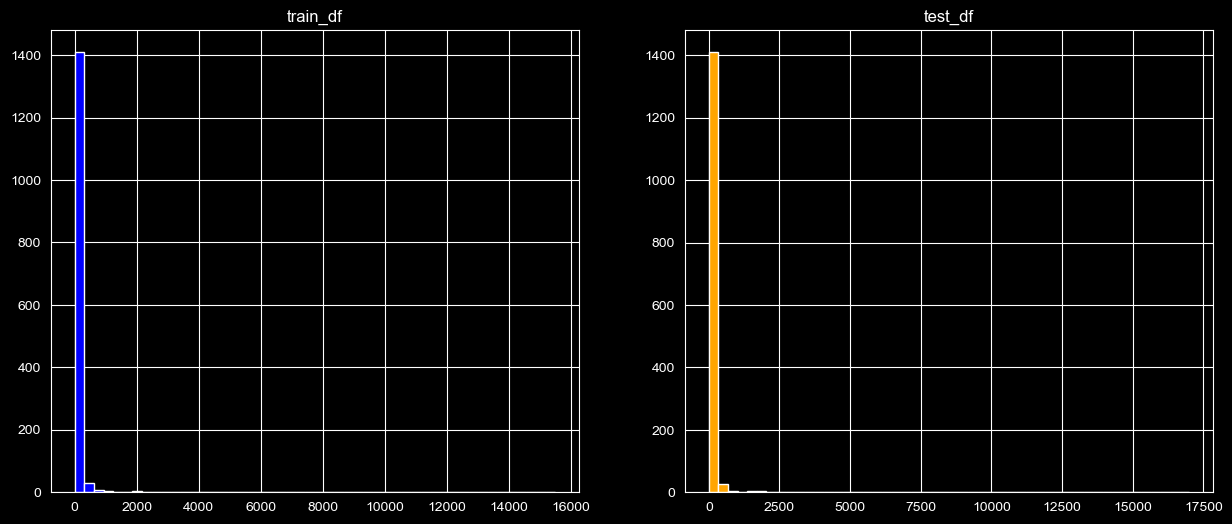

In [161]:
for num_col in num_cols:
    print(num_col)
    print(describe_col(num_col))
    plot_multi_hist(train_df, test_df, num_col, 'train_df', 'test_df', bins=50)

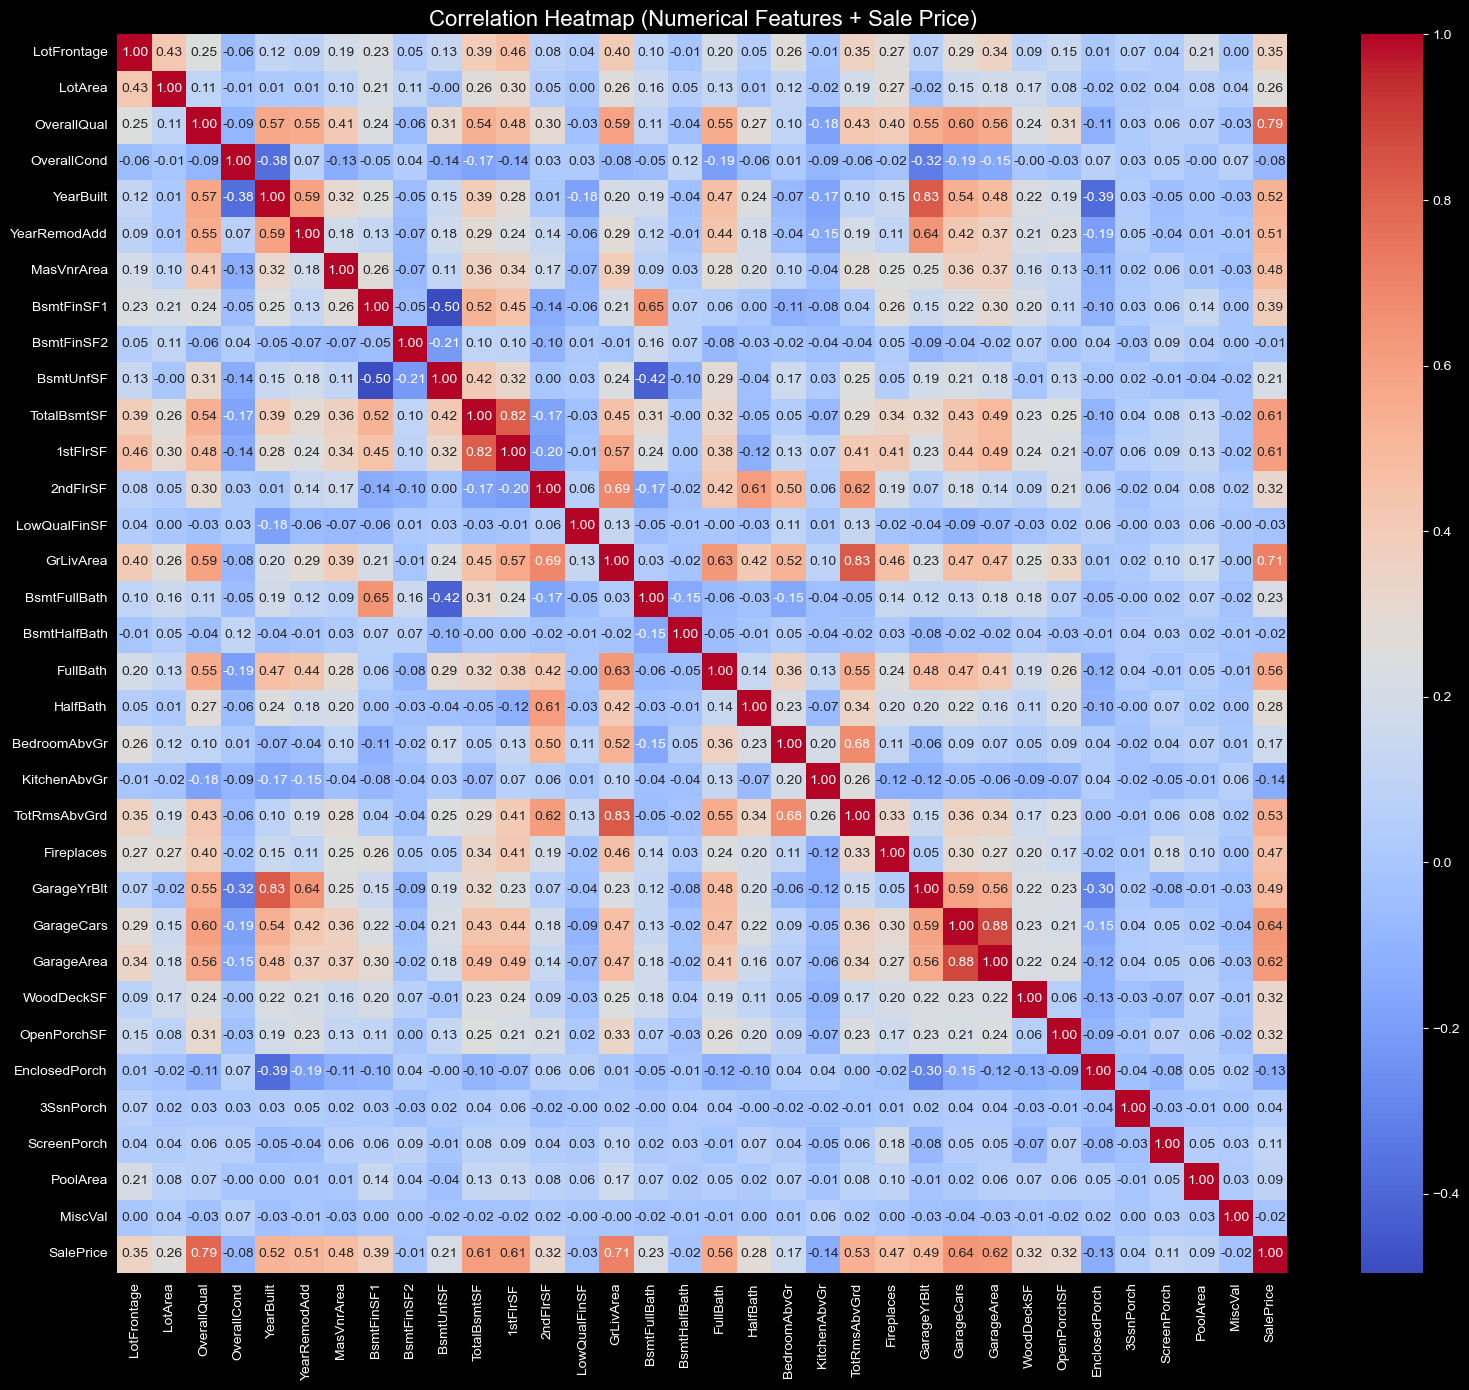

In [162]:
# Compute correlation matrix
corr_matrix = pd.concat([train_df[num_cols],train_df['SalePrice']],axis=1).corr()


# Plot heatmap
plt.figure(figsize=(16, 14))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap (Numerical Features + Sale Price)', fontsize=16)
plt.tight_layout()
plt.show()

Start to fill in the missing values. For objects that do not exist, replace NaN with 'None'.

In [163]:
train_df.loc[train_df['PoolArea'] == 0, 'PoolQC'] = 'None'
test_df.loc[test_df['PoolArea'] == 0, 'PoolQC'] = 'None'

train_df.loc[train_df['MiscVal']==0, 'MiscFeature'] = 'None'
test_df.loc[test_df['MiscVal']==0, 'MiscFeature'] = 'None'

train_df.loc[train_df['Alley'].isna(), 'Alley'] = 'None'
test_df.loc[test_df['Alley'].isna(), 'Alley'] = 'None'

train_df.loc[train_df['Fence'].isna(), 'Fence'] = 'None'
test_df.loc[test_df['Fence'].isna(), 'Fence'] = 'None'


train_df.loc[train_df['Fireplaces']==0, 'FireplaceQu'] = 'None'
test_df.loc[test_df['Fireplaces']==0, 'FireplaceQu'] = 'None'

train_df.loc[train_df['GarageArea']==0, ['GarageFinish', 'GarageType','GarageQual',
                                         'GarageCond']] = 'None'
test_df.loc[test_df['GarageArea']==0, ['GarageFinish', 'GarageType','GarageQual',
                                       'GarageCond']] = 'None'

train_df.loc[train_df['BsmtFinSF1'] == 0, 'BsmtFinType1'] = 'None'
test_df.loc[test_df['BsmtFinSF1'] == 0, 'BsmtFinType1'] = 'None'


train_df.loc[train_df['BsmtFinSF2'] == 0, 'BsmtFinType2'] = 'None'
test_df.loc[test_df['BsmtFinSF2'] == 0, 'BsmtFinType2'] = 'None'
""" - Without this causes an error occurs in xgboost because test set has Unf while train set does not """
test_df.loc[test_df['BsmtFinType2'] == 'Unf', 'BsmtFinType2'] = 'None'

train_df.loc[train_df['MasVnrArea'] == 0, 'MasVnrType'] = 'None'
test_df.loc[test_df['MasVnrArea'] == 0, 'MasVnrType'] = 'None'


train_df.loc[train_df['TotalBsmtSF'] == 0, ['BsmtCond', 'BsmtQual', 'BsmtExposure']] = 'None'
test_df.loc[test_df['TotalBsmtSF'] == 0, ['BsmtCond', 'BsmtQual', 'BsmtExposure']] = 'None'


In [164]:
print("Missing data in train_df:")
print(missing_data_table(train_df))
print("Missing data in test_df:")
print(missing_data_table(test_df))

Missing data in train_df:
              Total   Percent
LotFrontage     259  0.177397
GarageYrBlt      81  0.055479
MasVnrType       13  0.008904
MasVnrArea        8  0.005479
BsmtExposure      1  0.000685
Electrical        1  0.000685
BsmtFinType2      1  0.000685
Missing data in test_df:
              Total   Percent
LotFrontage     227  0.155586
GarageYrBlt      78  0.053461
MasVnrType       18  0.012337
MasVnrArea       15  0.010281
MSZoning          4  0.002742
BsmtCond          4  0.002742
BsmtQual          3  0.002056
BsmtExposure      3  0.002056
PoolQC            3  0.002056
Utilities         2  0.001371
Functional        2  0.001371
BsmtFullBath      2  0.001371
GarageCond        2  0.001371
GarageQual        2  0.001371
GarageFinish      2  0.001371
BsmtHalfBath      2  0.001371
BsmtFinSF2        1  0.000685
BsmtUnfSF         1  0.000685
BsmtFinType2      1  0.000685
BsmtFinSF1        1  0.000685
BsmtFinType1      1  0.000685
TotalBsmtSF       1  0.000685
KitchenQual       1

There are four columns in the train dataset that have missing values: MasVnrType, LotFrontage, GarageYrBl, MasVnrArea and Electricl. Looking at data description, MasVnrType is categorical and uses None to indicate no masonry veneer. Therefore, this column will not be imputed. LotFrontage,  GarageYrBlt and MasVnrArea are numerical columns and will need to be imputed.

There are 19 columns in the test dataset that have missing values. For the numerical columns, I will impute using the median value. For the categorical columns, I will impute using the mode.

Check PoolQC due to the high number of NaNs

In [165]:
print(train_df[train_df['PoolArea'] == 0]['PoolQC'].value_counts(dropna=False))
print(train_df[train_df['PoolArea'] != 0]['PoolQC'].value_counts(dropna=False))
print(len(train_df[train_df['PoolArea'] != 0]))

PoolQC
None    1453
Name: count, dtype: int64
PoolQC
Gd    3
Ex    2
Fa    2
Name: count, dtype: int64
7


High number of NaNs is due to very few houses having a pool.

In most cases, the garage and house should be built at the same time. Let's check if that is true in the data.

<Axes: >

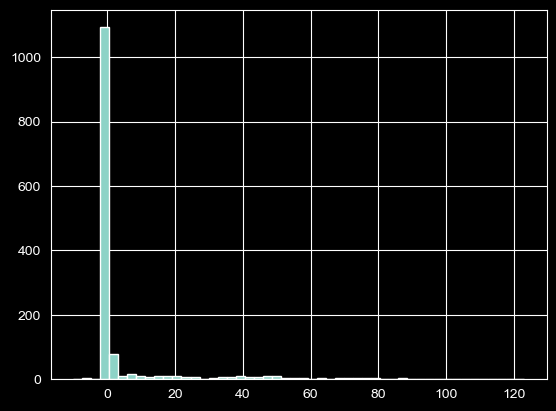

In [166]:
dif_gar_house_built = train_df['GarageYrBlt'] - train_df['YearBuilt']
dif_gar_house_built.hist(bins=50)

Assume that the lots are square so that lot frontage is the sqrt of the lot area.

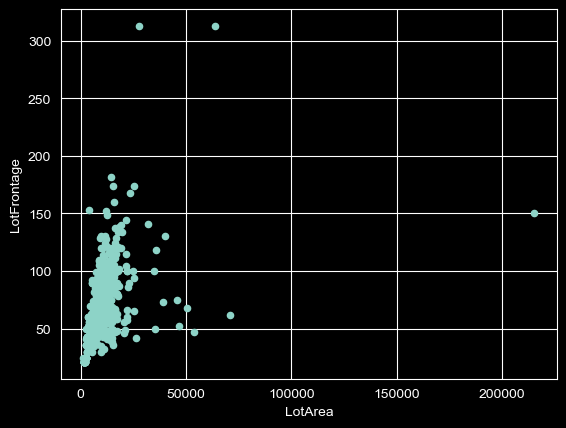

count    1201.000000
mean      -26.499856
std        22.045553
min      -313.945040
25%       -32.433760
50%       -24.852814
75%       -18.077641
max       146.717109
dtype: float64


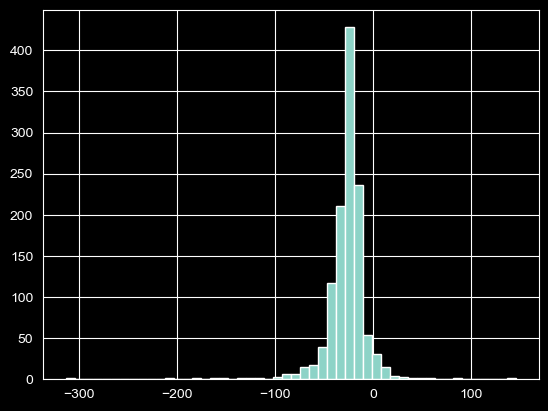

In [167]:
train_df.plot.scatter(x='LotArea', y='LotFrontage')
plt.show()

lot_front_area = train_df['LotFrontage'] - np.sqrt(train_df['LotArea'])
lot_front_area.hist(bins=50)
print(lot_front_area.describe())
mean_lot_frontage_shift = lot_front_area.mean()

For missing GarageYrBlt use YearBuilt. Fill electrical with the mode. Fill in lot frontage with the simple model.

In [168]:
train_df['GarageYrBlt'] = train_df['GarageYrBlt'].fillna(train_df['YearBuilt'])
train_df['Electrical'] = train_df['Electrical'].fillna(train_df['Electrical'].mode()[0])
train_df['LotFrontage'] = train_df['LotFrontage'].fillna(np.sqrt(train_df['LotArea']) + mean_lot_frontage_shift)

test_df['GarageYrBlt'] = test_df['GarageYrBlt'].fillna(test_df['YearBuilt'])
test_df['Electrical'] = test_df['Electrical'].fillna(test_df['Electrical'].mode()[0])
test_df['LotFrontage'] = test_df['LotFrontage'].fillna(np.sqrt(test_df['LotArea']) + mean_lot_frontage_shift)

In [169]:
print("Missing data in train_df:")
print(missing_data_table(train_df))
print("Missing data in test_df:")
print(missing_data_table(test_df))

Missing data in train_df:
              Total   Percent
MasVnrType       13  0.008904
MasVnrArea        8  0.005479
BsmtExposure      1  0.000685
BsmtFinType2      1  0.000685
Missing data in test_df:
              Total   Percent
MasVnrType       18  0.012337
MasVnrArea       15  0.010281
BsmtCond          4  0.002742
MSZoning          4  0.002742
PoolQC            3  0.002056
BsmtQual          3  0.002056
BsmtExposure      3  0.002056
BsmtFullBath      2  0.001371
BsmtHalfBath      2  0.001371
Functional        2  0.001371
GarageQual        2  0.001371
GarageCond        2  0.001371
Utilities         2  0.001371
GarageFinish      2  0.001371
BsmtFinSF1        1  0.000685
BsmtFinType1      1  0.000685
BsmtFinType2      1  0.000685
BsmtFinSF2        1  0.000685
BsmtUnfSF         1  0.000685
TotalBsmtSF       1  0.000685
KitchenQual       1  0.000685
Exterior1st       1  0.000685
Exterior2nd       1  0.000685
GarageCars        1  0.000685
MiscFeature       1  0.000685
SaleType          1

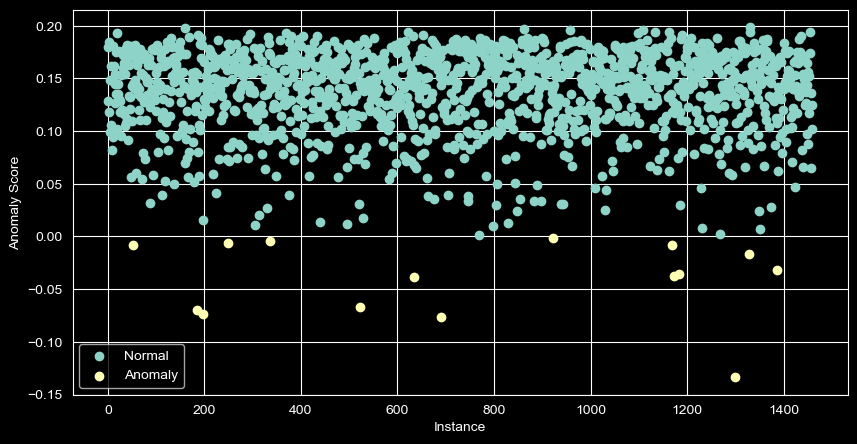

In [170]:
# Identify and remove outliers using Isolation Forest
iso_forest = IsolationForest(n_estimators=100, contamination=0.01, random_state=RANDOM_STATE)
iso_forest.fit(train_df[num_cols])

data = train_df.loc[train_df[num_cols].index].copy()
data['anomaly_score'] = iso_forest.decision_function(train_df[num_cols])
data['anomaly'] = iso_forest.predict(train_df[num_cols])

# Visualization of the results
plt.figure(figsize=(10, 5))

# Plot normal instances
normal = data[data['anomaly'] == 1]
plt.scatter(normal.index, normal['anomaly_score'], label='Normal')

# Plot anomalies
anomalies = data[data['anomaly'] == -1]
plt.scatter(anomalies.index, anomalies['anomaly_score'], label='Anomaly')
plt.xlabel("Instance")
plt.ylabel("Anomaly Score")
plt.legend()
plt.show()

normal_mask = data['anomaly'] == 1

train_df_masked = train_df[normal_mask]

In [171]:
# Define transformers for numerical and categorical columns
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ],remainder = 'passthrough')

# Create a pipeline with the preprocessor
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)]).set_output(transform="pandas")

X_preprocessed = pipeline.fit_transform(train_df_masked.drop(columns=['SalePrice']))
test_preprocessed = pipeline.transform(test_df.drop(columns=['Id']))

In [172]:
print("Missing data in X_preprocessed:")
print(missing_data_table(X_preprocessed))
print("Missing data in test_preprocessed:")
print(missing_data_table(test_preprocessed))

Missing data in X_preprocessed:
Empty DataFrame
Columns: [Total, Percent]
Index: []
Missing data in test_preprocessed:
Empty DataFrame
Columns: [Total, Percent]
Index: []


Function to describe the numerical columns. Description countains the count, mean std, min, percnetiles and max. I also added the percent missing.

Create some new features.

In [173]:
X_preprocessed['num__TotalBath'] = X_preprocessed['num__BsmtFullBath'] + 0.5*X_preprocessed['num__BsmtHalfBath'] + X_preprocessed['num__FullBath'] + 0.5*X_preprocessed['num__HalfBath']

test_preprocessed['num__TotalBath'] = test_preprocessed['num__BsmtFullBath'] + 0.5*test_preprocessed['num__BsmtHalfBath'] + test_preprocessed['num__FullBath'] + 0.5*test_preprocessed['num__HalfBath']

<class 'pandas.core.frame.DataFrame'>
Mean: 0.13723499141575052
Std: 0.010531766138043047


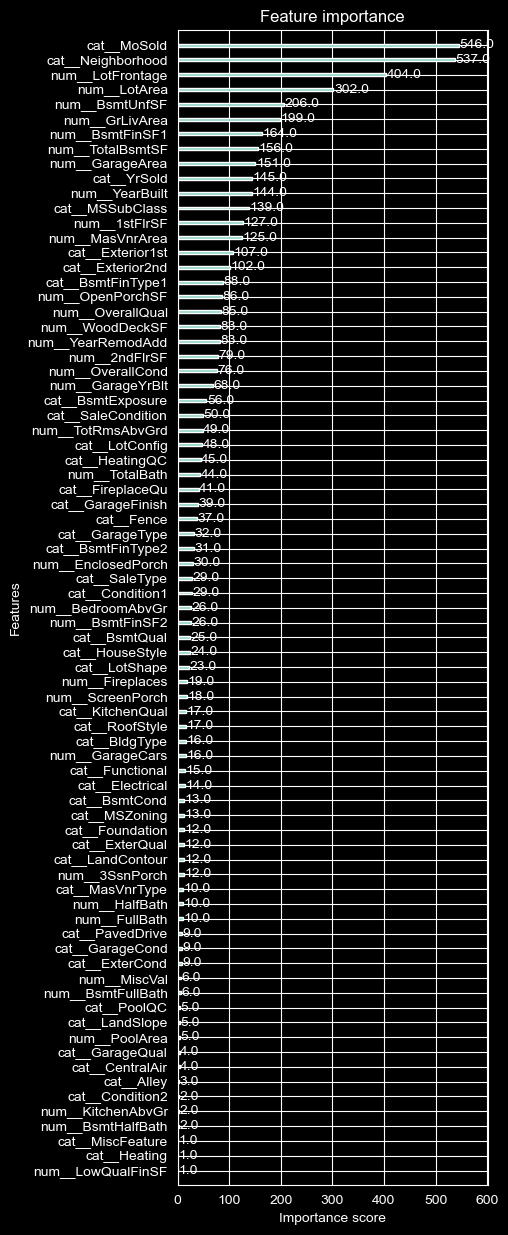

In [174]:
cat_cols_preprocessed = [x for x in X_preprocessed.columns if(x.startswith('cat__'))]
num_cols_preprocessed = [x for x in X_preprocessed.columns if(x.startswith('num__'))]

X = X_preprocessed
y = np.log(train_df_masked['SalePrice'])

print(type(X))

X[cat_cols_preprocessed] = X[cat_cols_preprocessed].astype('category')
test_preprocessed[cat_cols_preprocessed] = test_preprocessed[cat_cols_preprocessed].astype('category')
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE)

params = {
    "objective": "reg:squarederror",
    "seed": RANDOM_STATE,
    'enable_categorical': True,
    'early_stopping': 20,
    'n_estimators': 1000,
    'eval_metric': 'rmse'
}


cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
rsme_vals = []
test_preds = []
for train_idx, valid_idx in cv.split(X, y):
    model = xgb.XGBRegressor(**params)
    model.fit(
        X.iloc[train_idx], y.iloc[train_idx],
        eval_set=[(X.iloc[valid_idx], y.iloc[valid_idx])],
        verbose=False
    )
    preds = model.predict(X.iloc[valid_idx])
    rsme_vals.append(np.sqrt(mean_squared_error(y.iloc[valid_idx], preds)))
    prediction = model.predict(test_preprocessed)
    test_preds.append(prediction)
print("Mean:", np.mean(rsme_vals))
print("Std:", np.std(rsme_vals))


fig, ax = plt.subplots(figsize=(4, 15))
xgb.plot_importance(model, ax=ax)
plt.show()

In [175]:
test_preds = np.column_stack(test_preds)
final_pred = test_preds.mean(axis=1)
# Build submission
submission = pd.DataFrame({
    'Id': test_df['Id'].values,
    'SalePrice': np.exp(final_pred)
})

out_path = "submission.csv"
submission.to_csv(out_path, index=False)

In [176]:
def objective(trial):
    params = dict(
        objective='reg:squarederror',
        max_depth=trial.suggest_int("max_depth", 2, 10),
        learning_rate=trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
        n_estimators=trial.suggest_int("n_estimators", 1000, 8000),
        min_child_weight=trial.suggest_int("min_child_weight", 1, 10),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.2, 1.0),
        subsample=trial.suggest_float("subsample", 0.2, 1.0),
        reg_alpha=trial.suggest_float("reg_alpha", 1e-4, 1e2, log=True),
        reg_lambda=trial.suggest_float("reg_lambda", 1e-4, 1e2, log=True),
        seed=RANDOM_STATE,
        enable_categorical=True,
        early_stopping_rounds=20,
        pruning_callback = optuna.integration.XGBoostPruningCallback(trial, observation_key='validation_0-rmse')
    )



    cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    rsme = []
    for train_idx, valid_idx in cv.split(X, y):
        model = xgb.XGBRegressor(**params)
        model.fit(
            X_preprocessed.iloc[train_idx], y.iloc[train_idx],
            eval_set=[(X_preprocessed.iloc[valid_idx], y.iloc[valid_idx])],
            verbose=False
        )
        preds = model.predict(X_preprocessed.iloc[valid_idx])
        rsme.append(root_mean_squared_error(y.iloc[valid_idx], preds))
    return float(np.mean(rsme))

In [177]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)
xgb_params = study.best_params
print(xgb_params)

[I 2025-12-19 16:37:38,626] A new study created in memory with name: no-name-0165f6a4-0881-430e-99bf-80f3ef43b60c
[I 2025-12-19 16:38:02,723] Trial 0 finished with value: 0.14602854140331295 and parameters: {'max_depth': 2, 'learning_rate': 0.0016021119354783647, 'n_estimators': 6651, 'min_child_weight': 7, 'colsample_bytree': 0.28714035424718976, 'subsample': 0.26018181781913097, 'reg_alpha': 2.5953941124678925, 'reg_lambda': 8.527718800240875}. Best is trial 0 with value: 0.14602854140331295.
[I 2025-12-19 16:38:50,814] Trial 1 finished with value: 0.1969763034358508 and parameters: {'max_depth': 10, 'learning_rate': 0.0002531870752926828, 'n_estimators': 6568, 'min_child_weight': 7, 'colsample_bytree': 0.5688679012431209, 'subsample': 0.20628639001627597, 'reg_alpha': 1.3146937227798738, 'reg_lambda': 0.3834422475708879}. Best is trial 0 with value: 0.14602854140331295.
[I 2025-12-19 16:39:15,213] Trial 2 finished with value: 0.11727550831660796 and parameters: {'max_depth': 7, 'lea

{'max_depth': 10, 'learning_rate': 0.003044648327707474, 'n_estimators': 4249, 'min_child_weight': 6, 'colsample_bytree': 0.7399385032521721, 'subsample': 0.31875452895923734, 'reg_alpha': 0.00018506404577425017, 'reg_lambda': 0.0001931412304236234}


In [178]:
xgb_params

{'max_depth': 10,
 'learning_rate': 0.003044648327707474,
 'n_estimators': 4249,
 'min_child_weight': 6,
 'colsample_bytree': 0.7399385032521721,
 'subsample': 0.31875452895923734,
 'reg_alpha': 0.00018506404577425017,
 'reg_lambda': 0.0001931412304236234}

In [179]:
xgb_params.update({
    "objective": "reg:squarederror",
    "seed": RANDOM_STATE,
    'enable_categorical': True,
    'eval_metric': 'rmse'
    })

model = xgb.XGBRegressor(**xgb_params)
# XGB minimizes MSE, but competition loss is RMSLE
# So, we need to log-transform y to train and exp-transform the predictions
model.fit(X_preprocessed, y)
prediction = model.predict(test_preprocessed)

# Build submission
submission = pd.DataFrame({
    'Id': test_df['Id'].values,
    'SalePrice': np.exp(final_pred)
})

out_path = "submission.csv"
submission.to_csv(out_path, index=False)